## Robustness between donors

Compare DE effects predictions on different pairs of donors

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os,sys
import numpy as np
import anndata
import pandas as pd
import mudata as md
import scanpy as sc
import glob
from tqdm import tqdm
import scipy
from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Configure matplotlib for Illustrator-compatible PDFs
mpl.rcParams['pdf.fonttype'] = 42  # Embed fonts as TrueType
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 300  # or 150, 200, etc.
plt.rcParams['savefig.dpi'] = 300

# Increase all font sizes
plt.rcParams['font.size'] = 16  # Base font size
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15


from copy import deepcopy
from tqdm import tqdm
# from DE_analysis_utils import *

In [4]:
import yaml

# Load color palettes from yaml file
with open('../../../metadata/figure_palettes.yaml', 'r') as f:
    palettes = yaml.safe_load(f)

In [5]:
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 300  # or 150, 200, etc.
plt.rcParams['savefig.dpi'] = 300

In [6]:
datadir = '/mnt/oak/users/emma/data/GWT/CD4i_final/'
experiment_name = 'CD4i_final'
results_dir = datadir + 'donor_robustness_analysis/'
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

In [7]:
def get_reliability(x, sigma):
    sigma2_obs = np.var(x, ddof=1)  # Observed variance across features
    sigma2_sem = np.mean(sigma**2)   # Average squared standard error
    sigma2_true = sigma2_obs - sigma2_sem  # Estimated true signal variance
    reliability = sigma2_true / (sigma2_true + sigma2_sem)
    return(reliability)

def get_max_correlation(x_a, sigma_a, x_b, sigma_b):
    """Calculate maximum possible correlation"""
    rel_a = get_reliability(x_a, sigma_a)
    rel_b = get_reliability(x_b, sigma_b)
    return np.sqrt(rel_a * rel_b)

def get_lfc_correlation(x_a, sigma_a, x_b, sigma_b):
    """Calculate maximum possible correlation"""
    corr = x_a.corr(x_b)
    corr_ceil = get_max_correlation(x_a, sigma_a, x_b, sigma_b)
    return corr, corr_ceil

In [9]:
de_counts = pd.read_csv(f'{datadir}/DE_results_all_confounders/DE_summary_stats_per_target.csv', index_col=0)

In [10]:
de_counts.head()

target_contrast target_name condition  n_cells_target  n_up_genes  \
0  ENSG00000012963        UBR7   Stim8hr           491.0           0   
1  ENSG00000017260      ATP2C1   Stim8hr           469.0           0   
2  ENSG00000067606       PRKCZ   Stim8hr           427.0           1   
3  ENSG00000092929      UNC13D   Stim8hr           830.0           0   
4  ENSG00000100504        PYGL   Stim8hr           414.0           1   

   n_down_genes  n_total_de_genes  ontarget_effect_size  ontarget_significant  \
0             2                 2            -12.952742                  True   
1             1                 1            -16.307246                  True   
2             1                 2             -1.658755                 False   
3             2                 2            -19.259466                  True   
4             0                 1                   NaN                 False   

     baseMean  offtarget_flag n_total_genes_category ontarget_effect_category  
0   43.169196            True          2-10 DE genes             on-target KD  
1  102.399025           False              1 DE gene             on-target KD  
2    0.965897           False          2-10 DE genes          no on-target KD  
3   60.904483           False          2-10 DE genes             on-target KD  
4         NaN           False              1 DE gene          no on-target KD

## Random sample of perturbations

Read outputs of `get_donor_robustness.py`

In [11]:
parquet_files = glob.glob(f"{results_dir}/DE_donor_robustness.ENS*_*.parquet")
all_results_df = pd.concat([pd.read_parquet(f) for f in parquet_files], ignore_index=True)
all_results_df['zscore'] = all_results_df['log_fc']/all_results_df['lfcSE']
all_results_df.head()

variable    baseMean    log_fc     lfcSE       stat       p_value  \
0  ENSG00000114030   90.085227 -2.707964  0.185930 -14.564423  4.729612e-48   
1  ENSG00000168243   55.315931  1.228838  0.288682   4.256723  2.074453e-05   
2  ENSG00000100336    2.593646  1.944916  0.474007   4.103139  4.075815e-05   
3  ENSG00000115163   34.162005  0.980832  0.259444   3.780514  1.565046e-04   
4  ENSG00000121039  318.552322  0.781206  0.212988   3.667835  2.446128e-04   

    adj_p_value           target culture_condition  n_cells  n_donors  \
0  6.820101e-44  ENSG00000114030           Stim8hr    240.0         2   
1  1.495681e-01  ENSG00000114030           Stim8hr    240.0         2   
2  1.959108e-01  ENSG00000114030           Stim8hr    240.0         2   
3  5.353882e-01  ENSG00000114030           Stim8hr    240.0         2   
4  5.353882e-01  ENSG00000114030           Stim8hr    240.0         2   

                donors  signif     zscore  
0  CE0006864_CE0008162    True -14.564423  
1  CE0006864_CE0008162   False   4.256723  
2  CE0006864_CE0008162   False   4.103139  
3  CE0006864_CE0008162   False   3.780514  
4  CE0006864_CE0008162   False   3.667835

In [12]:
all_results_df[['target', 'culture_condition']].drop_duplicates().value_counts('culture_condition')

culture_condition
Stim8hr     100
Stim48hr     98
Rest         82
Name: count, dtype: int64

### Compute correlation of DE effects

In [13]:
import itertools

conditions = ['Stim8hr', 'Stim48hr', 'Rest']
all_correlations = pd.DataFrame()

for cond in conditions:
    selected_regulators = pd.read_table(f"{results_dir}/selected_targets_robustness_{cond}.txt", header=None)[0].tolist()
    cond_results_df = all_results_df[(all_results_df['culture_condition'] == cond)]

    donor_pairs = cond_results_df['donors'].unique()
    comparison_pairs = []
    for pair1, pair2 in itertools.combinations(donor_pairs, 2):
        donors1 = set(pair1.split('_'))
        donors2 = set(pair2.split('_'))
        if donors1.isdisjoint(donors2):
            comparison_pairs.append((pair1, pair2))

    pivoted = cond_results_df.pivot(columns='donors', index=['target','variable'], values='log_fc')
    pivoted_se = cond_results_df.pivot(columns='donors', index=['target','variable'], values='lfcSE')
    pivoted_pval = cond_results_df.pivot(columns='donors', index=['target','variable'], values='adj_p_value')
    
    correlations = pd.DataFrame()
    for target in tqdm(pivoted.index.get_level_values('target').unique()):
        target_data = pivoted.loc[target]
        target_se = pivoted_se.loc[target]
        target_p = pivoted_pval.loc[target]
        
        # Calculate correlations and F1 scores for specified pairs
        pair_correlations = []
        for pair in comparison_pairs:
            if pair[0] in target_data.columns and pair[1] in target_data.columns:
                # Get mask for genes with p < 0.1 in either test
                sig_mask = (target_p[pair[0]] < 0.2) | (target_p[pair[1]] < 0.2)
                # sig_mask = (np.abs(target_data[pair[0]]) > 0.1) | (np.abs(target_data[pair[1]]) > 0.1)
                
                # Filter data using mask
                data1 = target_data[pair[0]][sig_mask]
                data2 = target_data[pair[1]][sig_mask]
                se1 = target_se[pair[0]][sig_mask]
                se2 = target_se[pair[1]][sig_mask]
                
                corr, corr_ceil = get_lfc_correlation(data1, se1, data2, se2)

                pair_correlations.append({
                    'target': target,
                    'donors': pair[0],
                    'variable': pair[1],
                    'correlation': corr,
                    'correlation_ceiling': corr_ceil,
                    'n_signif': data1.shape[0],
                    'culture_condition': cond
                })
        correlations = pd.concat([correlations, pd.DataFrame(pair_correlations)])

    correlations = pd.merge(correlations.rename({'target':'target_contrast'}, axis=1), de_counts, how='left')
    correlations = correlations[correlations.target_name.isin(selected_regulators)]
    all_correlations = pd.concat([all_correlations, correlations])

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_1527967/3615270918.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(rel_a * rel_b)
 43%|████▎     | 43/100 [00:00<00:00, 138.75it/s]/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
  0%|          | 0/98 [00:00<?, ?it/s]/tmp/ipykernel_1527967/3615270918.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(rel_a * rel_b)
 13%|█▎        | 13/98 [00:00<00:00, 126.72it/s]/home/emm

In [15]:
all_correlations[all_correlations['n_signif'] > 1][['culture_condition','target_name']].drop_duplicates().value_counts('culture_condition')

culture_condition
Rest        50
Stim48hr    50
Stim8hr     50
Name: count, dtype: int64

/tmp/ipykernel_1527967/1185219528.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = all_correlations.groupby(['target_name', 'culture_condition']).agg({


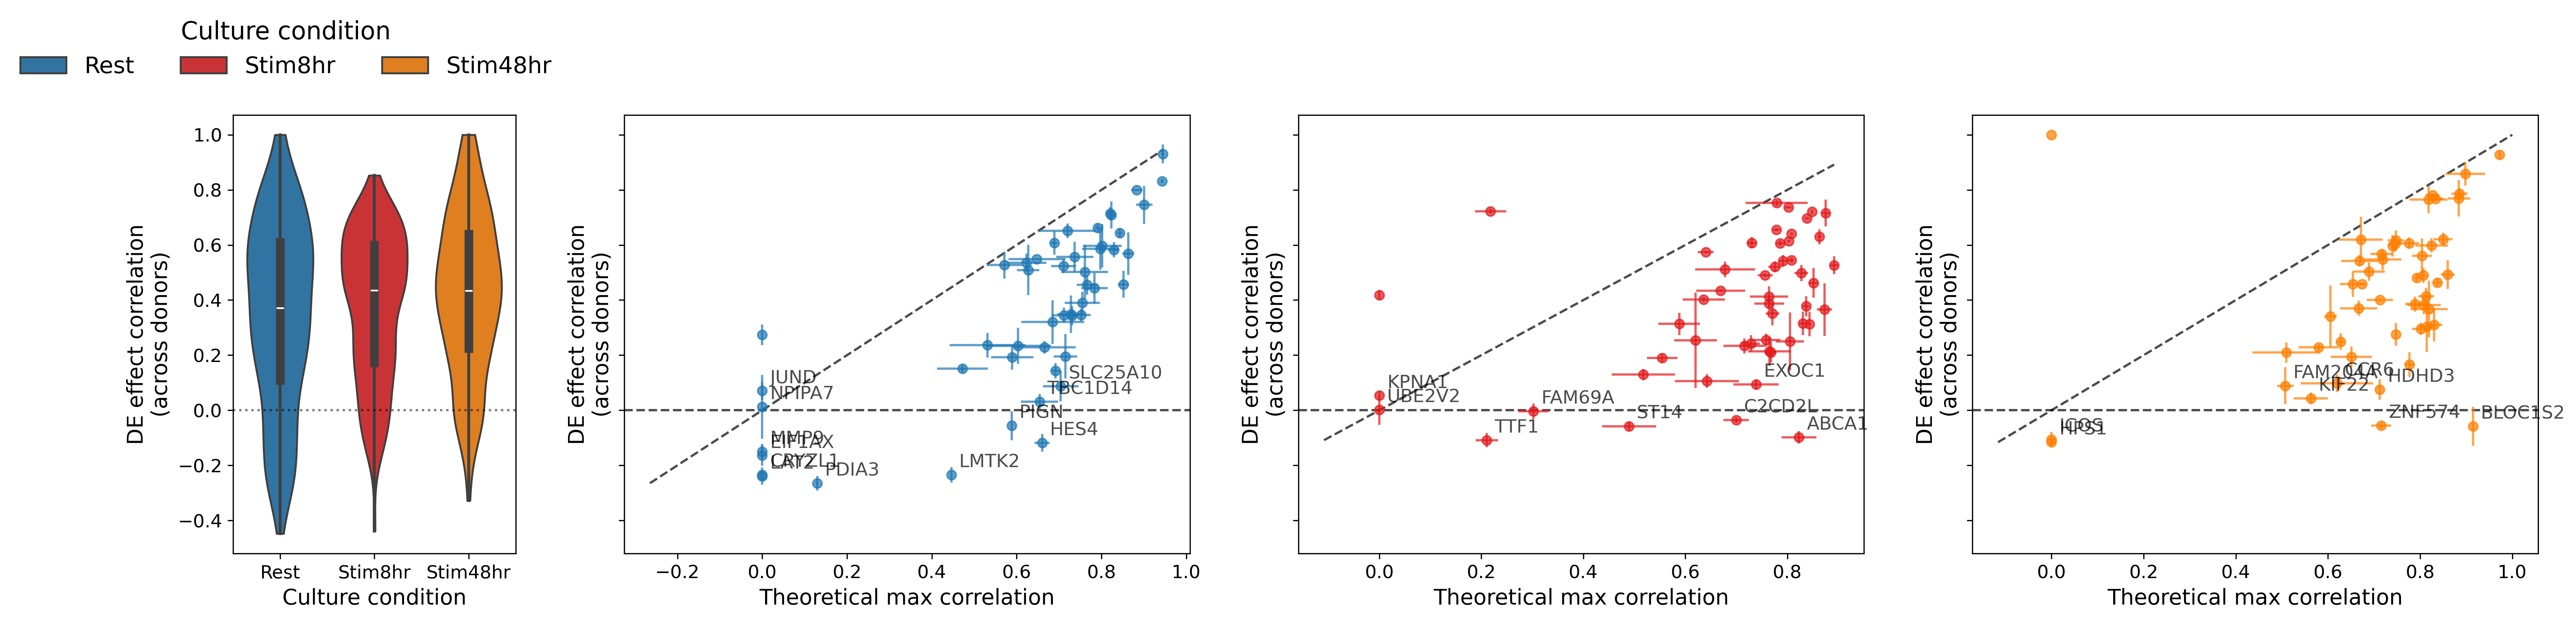

In [35]:
# Calculate mean and standard error per target and condition
summary_stats = all_correlations.groupby(['target_name', 'culture_condition']).agg({
    'correlation': ['mean', 'std', 'count'],
    'correlation_ceiling': ['mean', 'std']
}).reset_index()

# Fill NAs in correlation_ceiling with 0
summary_stats[('correlation_ceiling', 'mean')] = summary_stats[('correlation_ceiling', 'mean')].fillna(0)
summary_stats[('correlation_ceiling', 'std')] = summary_stats[('correlation_ceiling', 'std')].fillna(0)

# Calculate standard errors
summary_stats['correlation_se'] = summary_stats[('correlation', 'std')] / np.sqrt(summary_stats[('correlation', 'count')])
summary_stats['correlation_ceiling_se'] = summary_stats[('correlation_ceiling', 'std')] / np.sqrt(summary_stats[('correlation', 'count')])

# Create figure with subplots for each condition plus boxplot
conditions = ['Rest', 'Stim8hr', 'Stim48hr']
ylabel = 'DE effect correlation\n(across donors)'
all_correlations['culture_condition'] = all_correlations['culture_condition'].astype('category').cat.reorder_categories(conditions)
fig, axes = plt.subplots(1, len(conditions) + 1, figsize=(6*(len(conditions) + 1), 6), sharey=True, gridspec_kw={'width_ratios': [1, 2, 2, 2]})

# Add violinplot in the first subplot with reduced width
sns.violinplot(data=all_correlations.reset_index(), x='culture_condition', y='correlation', hue='culture_condition', ax=axes[0],
            order=conditions, palette=palettes['culture_condition'], density_norm='width', cut=0, width=0.7,
            legend=True)
axes[0].legend(title='Culture condition', bbox_to_anchor=(1.2, 1.15), loc='right', ncol=3, frameon=False)
axes[0].set_xlabel('Culture condition', fontsize=14)
axes[0].set_ylabel(ylabel, fontsize=14)
axes[0].tick_params(axis='both', labelsize=12)
axes[0].axhline(y=0, color='black', linestyle=':', alpha=0.5)  # Add dotted line at y=0

for i, condition in enumerate(conditions):
    condition_stats = summary_stats[summary_stats['culture_condition'] == condition]
    
    # Get axis limits for this condition
    min_val = min(condition_stats[('correlation_ceiling', 'mean')].min(), condition_stats[('correlation', 'mean')].min())
    max_val = max(condition_stats[('correlation_ceiling', 'mean')].max(), condition_stats[('correlation', 'mean')].max())
    
    # Add diagonal line
    axes[i+1].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.7)
    axes[i+1].axhline(0, color='black', linestyle='--', alpha=0.7)
    
    # Plot error bars
    axes[i+1].errorbar(x=condition_stats[('correlation_ceiling', 'mean')],
                    y=condition_stats[('correlation', 'mean')],
                    xerr=condition_stats['correlation_ceiling_se'],
                    yerr=condition_stats['correlation_se'],
                    fmt='o',
                    color=palettes['culture_condition'][condition],
                    alpha=0.7)
    
    # Add labels with increased font size
    axes[i+1].set_xlabel('Theoretical max correlation', fontsize=14)
    axes[i+1].set_ylabel(ylabel, fontsize=14)
    axes[i+1].tick_params(axis='both', labelsize=12)
    
    # Add target names as annotations only for genes with mean correlation < 0.1
    for j, target in enumerate(condition_stats['target_name']):
        if condition_stats[('correlation', 'mean')].iloc[j] < 0.1:
            axes[i+1].annotate(target,
                           (condition_stats[('correlation_ceiling', 'mean')].iloc[j],
                            condition_stats[('correlation', 'mean')].iloc[j]),
                           xytext=(5, 5), textcoords='offset points',
                           alpha=0.7,
                           fontsize=12)

plt.tight_layout(w_pad=0.5)
plt.savefig('../results/donor_robustness_figure.pdf')
plt.savefig('../results/donor_robustness_figure.png')

/tmp/ipykernel_1395471/3072865098.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')


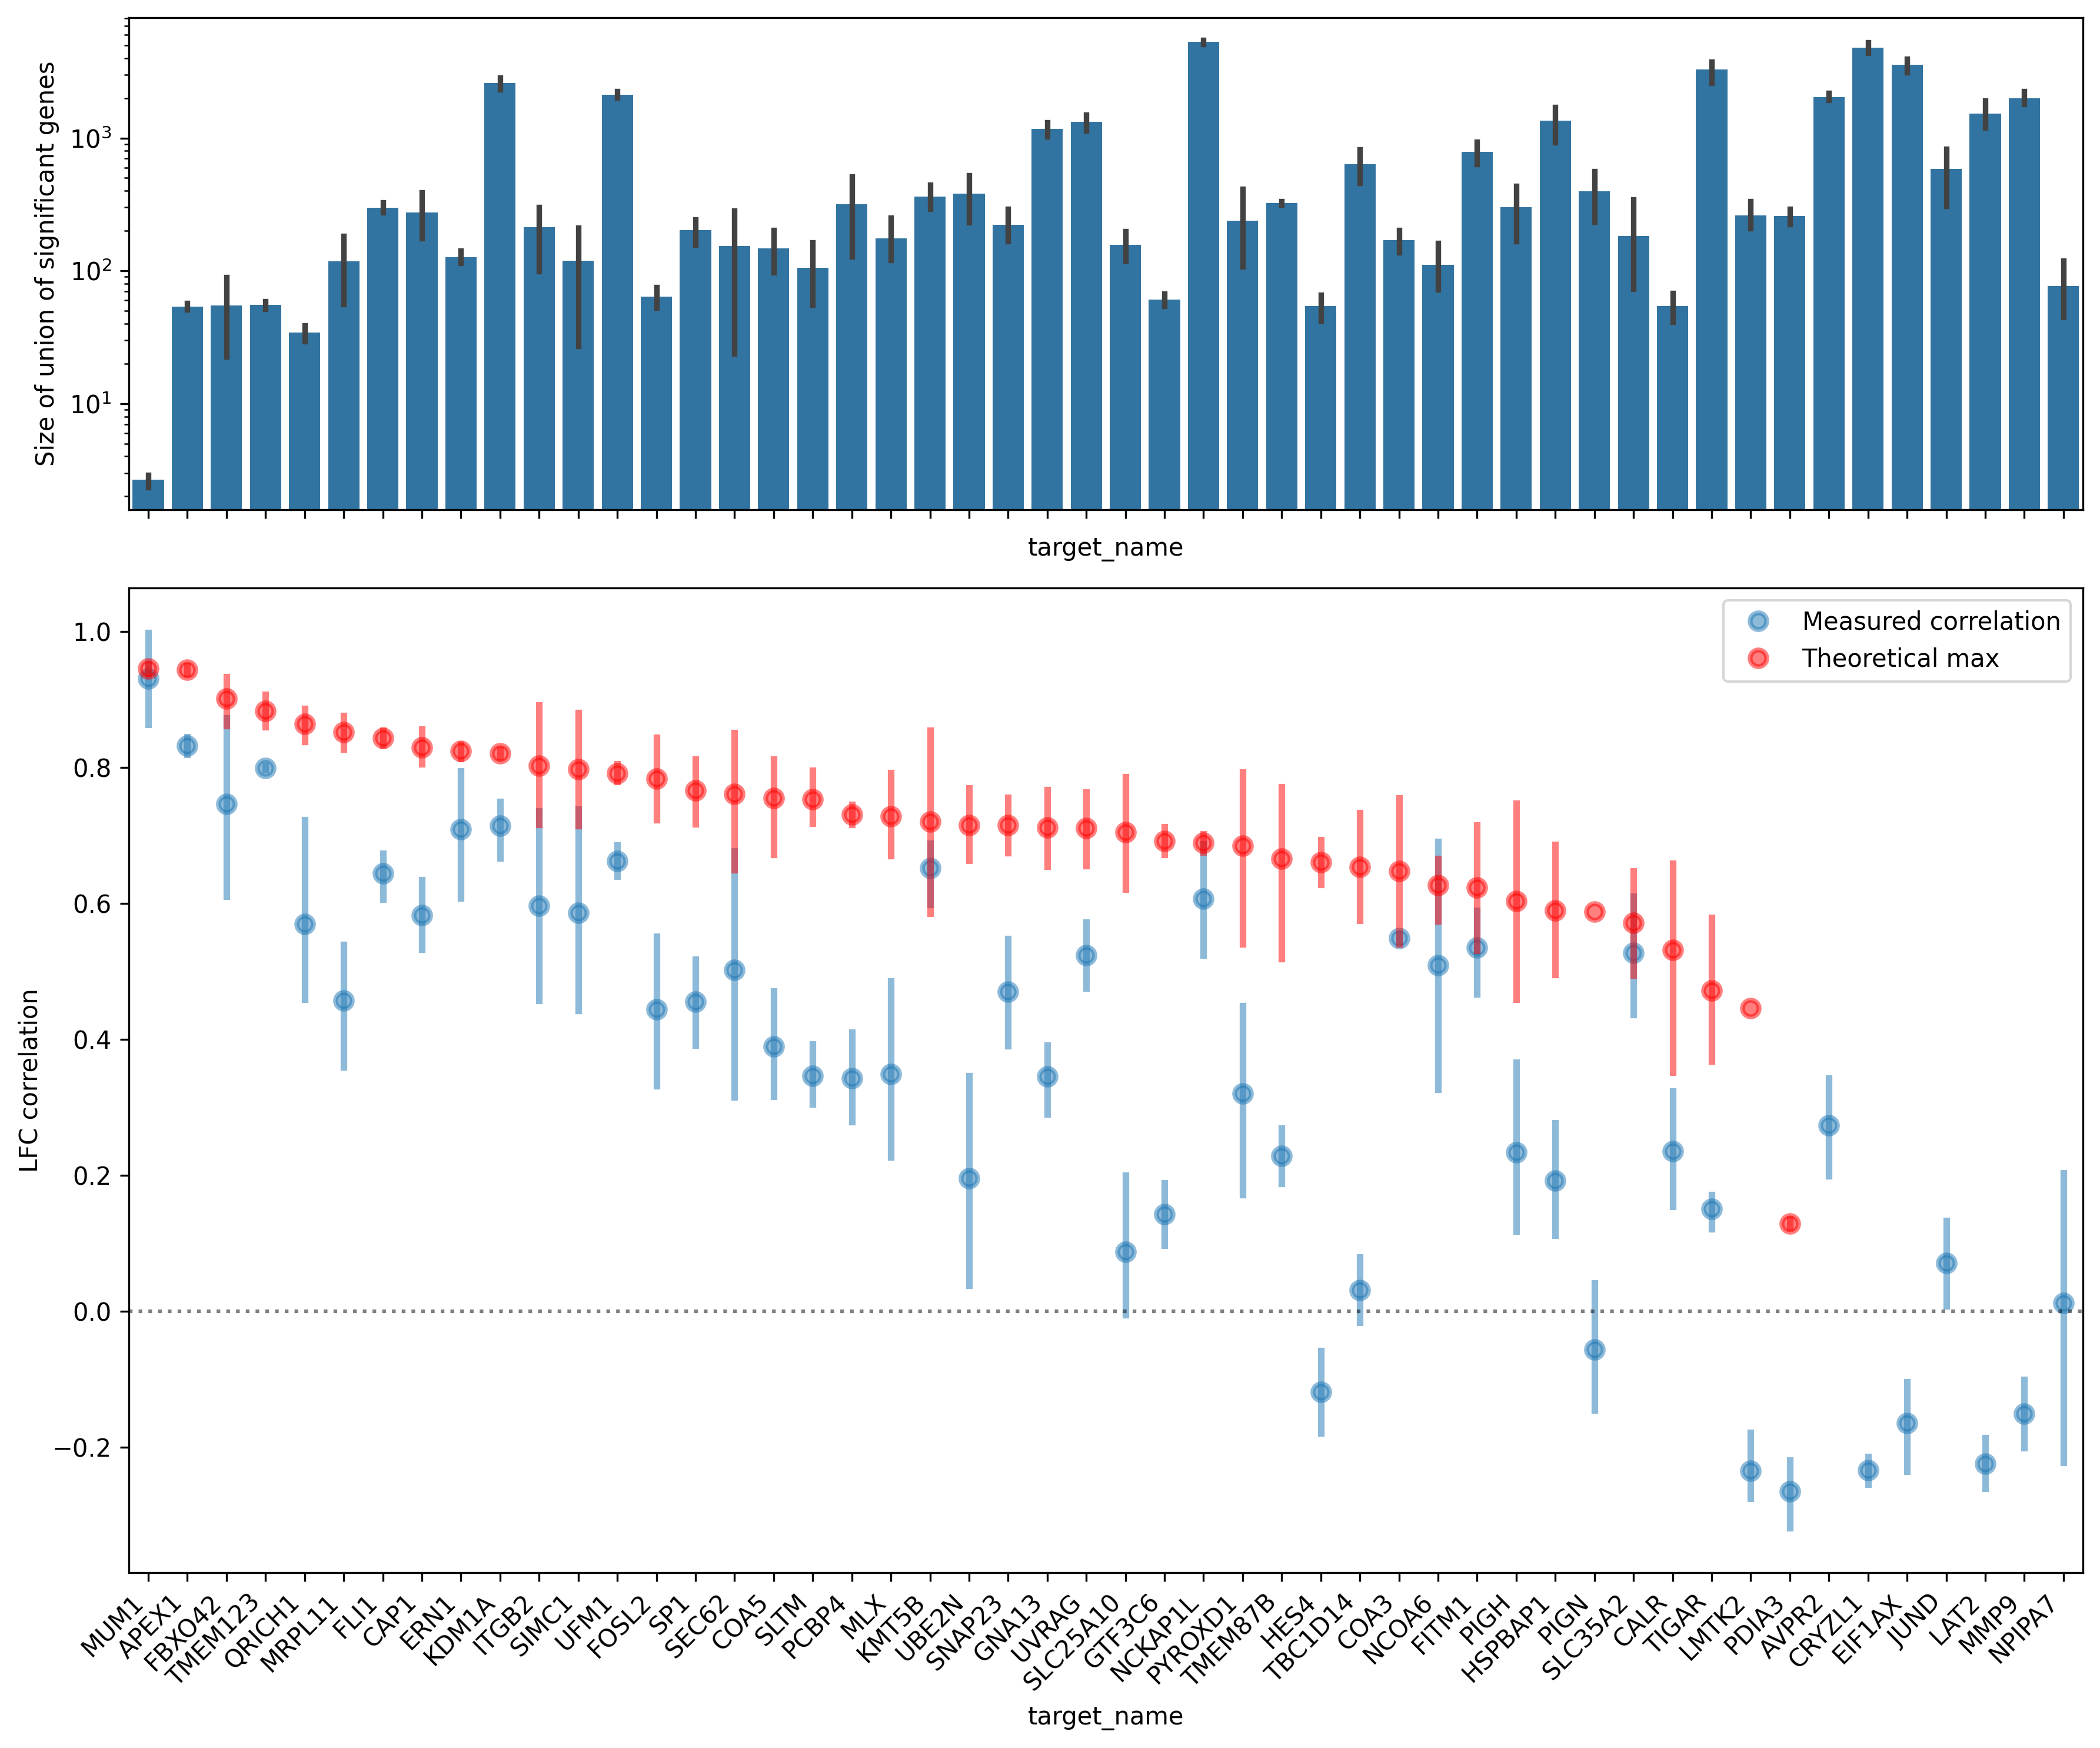

In [ ]:
# Calculate mean correlation per target to sort by
mean_corr = correlations.groupby('target_name')['correlation_ceiling'].mean().sort_values(ascending=False)
sorted_targets = mean_corr.index

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[1, 2])

# Top subplot - mean number of significant genes
sns.barplot(data=correlations, x='target_name', y='n_signif', ax=ax1, order=sorted_targets)
ax1.set_xticklabels([]) # Hide x labels on top plot
ax1.set_ylabel('Size of union of significant genes')
ax1.set_yscale('log')

# Bottom subplot - correlations
sns.pointplot(data=correlations, x='target_name', y='correlation',
              order=sorted_targets, alpha=0.5, ax=ax2, linestyles='', label='Measured correlation')
sns.pointplot(data=correlations, x='target_name', y='correlation_ceiling',
              order=sorted_targets, alpha=0.5, color='red', ax=ax2, linestyles='', label='Theoretical max')
ax2.axhline(y=0, color='black', linestyle=':', alpha=0.5)
ax2.set_ylabel('LFC correlation')
# Add legend inside plot
ax2.legend(bbox_to_anchor=(1, 1))


# Rotate x-axis labels for readability
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

# Adjust layout to prevent label cutoff
plt.tight_layout()

Text(0, 0.5, 'CE0008162_CE0010866')

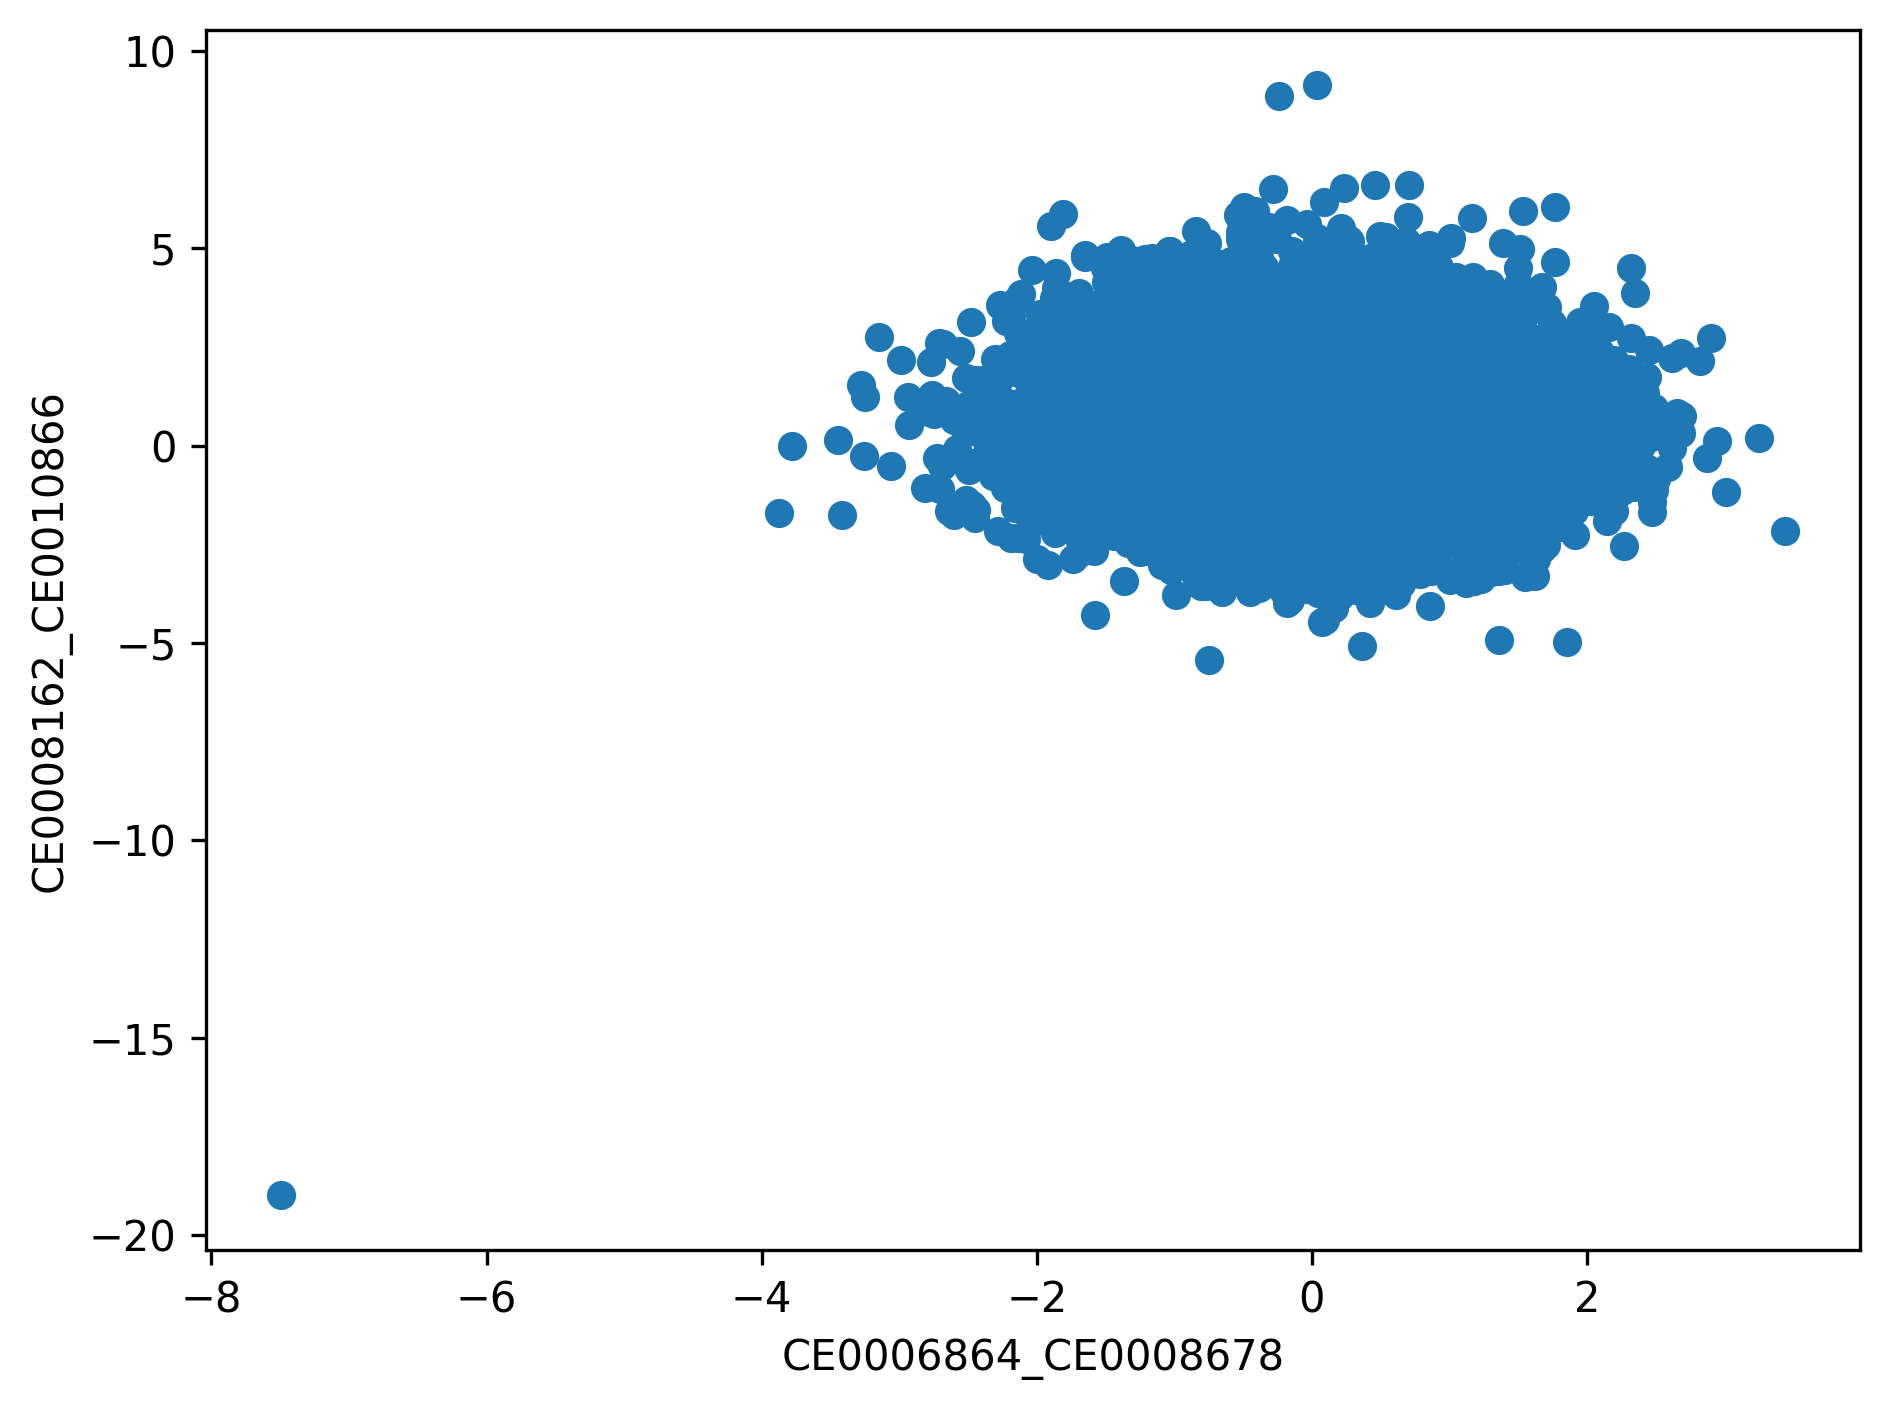

In [75]:
pl_df = all_results_df[all_results_df['target'] == 'ENSG00000163600'].pivot(columns='donors', values='zscore', index='variable')

pair_ix = 2
plt.scatter(pl_df[comparison_pairs[pair_ix][0]], pl_df[comparison_pairs[pair_ix][1]])
plt.xlabel(comparison_pairs[pair_ix][0])
plt.ylabel(comparison_pairs[pair_ix][1])

In [8]:
from DE_analysis_utils import *

In [10]:
selected_perturbed_genes = ['IL2RA']
pbulk_adata = anndata.experimental.read_lazy('/mnt/oak/users/emma/data/GWT/CD4i_final/CD4i_final_merged.DE_pseudobulk.h5ad')
pbulk_adata_test = pbulk_adata[pbulk_adata.obs['perturbed_gene_name'].isin(selected_perturbed_genes + ['NTC'])].to_memory()
# pbulk_adata_test = pbulk_adata_test[pbulk_adata_test.obs['culture_condition'] == cond].copy()
sc.pp.normalize_total(pbulk_adata_test)
sc.pp.log1p(pbulk_adata_test)

<Axes: title={'center': 'IL2RA expression by IL2RA vs NTC in Stim48hr'}, xlabel='perturbed_gene_name', ylabel='IL2RA expression'>

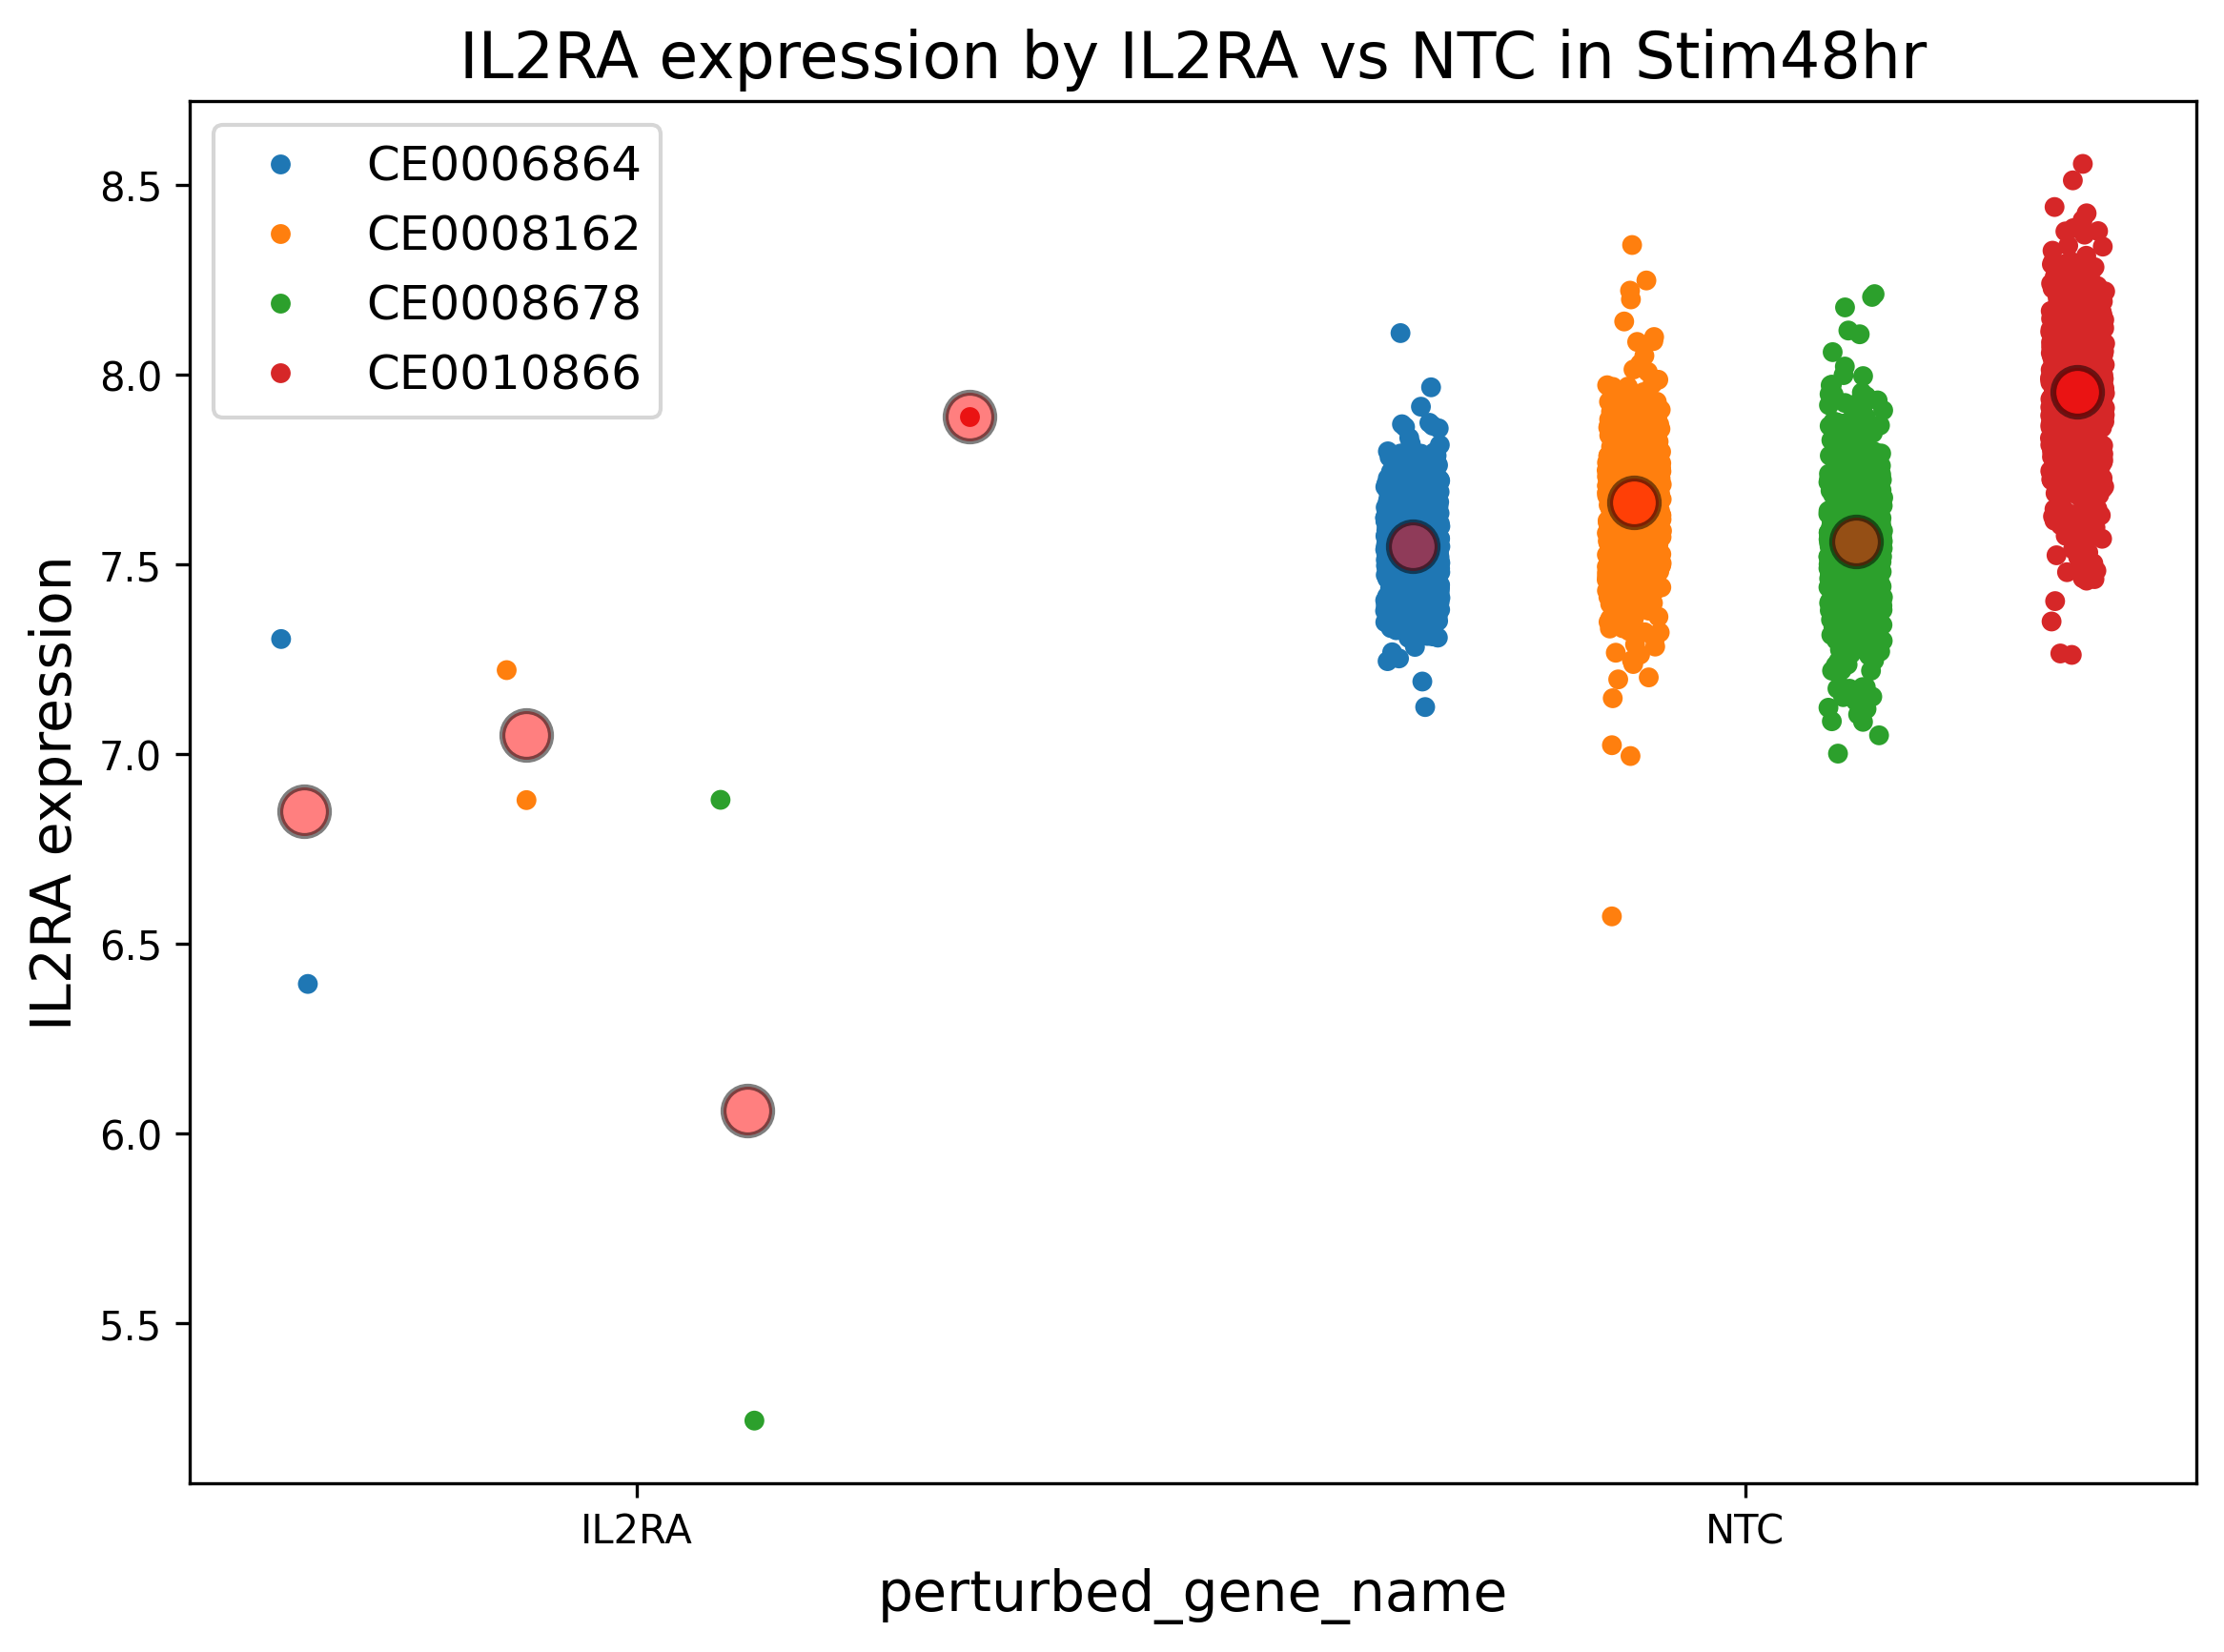

In [11]:
plot_gene_expression_by_target(pbulk_adata_test, 'IL2RA', 'IL2RA', condition='Stim48hr', hue='donor_id',
                                  target_name_col='perturbed_gene_name', gene_name_col='gene_name')



## Th2 regulators

Using list curated by Ron

```bash
PERTURBS=$(tr '\n' ',' < th2regulators.txt | sed 's/,$//')
python get_donor_robustness.py --condition Stim8hr --target $PERTURBS
```

Read outputs of `get_donor_robustness.py`

In [11]:
cond = 'Stim8hr'
Th2_regulators = pd.read_table('th2regulators.txt', header=None)[0].tolist()

parquet_files = glob.glob(f"{results_dir}/DE_donor_robustness.*.parquet")
all_results_df = pd.concat([pd.read_parquet(f) for f in parquet_files], ignore_index=True)
all_results_df['zscore'] = all_results_df['log_fc']/all_results_df['lfcSE']
all_results_df = all_results_df[all_results_df['culture_condition'] == cond]
all_results_df

variable    baseMean    log_fc     lfcSE      stat   p_value  \
0        ENSG00000135829  200.469956  0.220522  0.057391  3.842479  0.000122   
1        ENSG00000105618  180.605080  0.213724  0.055884  3.824427  0.000131   
2        ENSG00000141905    9.420225  0.783465  0.211871  3.697845  0.000217   
3        ENSG00000107077   41.793312  0.391626  0.107818  3.632295  0.000281   
4        ENSG00000090372   62.520677  0.309093  0.085245  3.625948  0.000288   
...                  ...         ...       ...       ...       ...       ...   
2516523  ENSG00000158691    3.767356  0.000092  0.329593  0.000278  0.999778   
2516524  ENSG00000089723    2.580450  0.000141  0.607739  0.000232  0.999815   
2516525  ENSG00000141030  106.620820 -0.000004  0.073777 -0.000059  0.999953   
2516526  ENSG00000112115    1.868006 -1.741139  3.178153 -0.547846       NaN   
2516527  ENSG00000112116    5.843813 -2.197126  2.583277 -0.850519       NaN   

         adj_p_value           target culture_condition  n_cells  n_donors  \
0           0.683430  ENSG00000086730           Stim8hr    242.0         2   
1           0.683430  ENSG00000086730           Stim8hr    242.0         2   
2           0.683430  ENSG00000086730           Stim8hr    242.0         2   
3           0.683430  ENSG00000086730           Stim8hr    242.0         2   
4           0.683430  ENSG00000086730           Stim8hr    242.0         2   
...              ...              ...               ...      ...       ...   
2516523     0.999909  ENSG00000015285           Stim8hr    289.0         2   
2516524     0.999909  ENSG00000015285           Stim8hr    289.0         2   
2516525     0.999953  ENSG00000015285           Stim8hr    289.0         2   
2516526          NaN  ENSG00000015285           Stim8hr    289.0         2   
2516527          NaN  ENSG00000015285           Stim8hr    289.0         2   

                      donors  signif    zscore  
0        CE0006864_CE0008162   False  3.842479  
1        CE0006864_CE0008162   False  3.824427  
2        CE0006864_CE0008162   False  3.697845  
3        CE0006864_CE0008162   False  3.632295  
4        CE0006864_CE0008162   False  3.625948  
...                      ...     ...       ...  
2516523  CE0010866_CE0008678   False  0.000278  
2516524  CE0010866_CE0008678   False  0.000232  
2516525  CE0010866_CE0008678   False -0.000059  
2516526  CE0010866_CE0008678   False -0.547846  
2516527  CE0010866_CE0008678   False -0.850519  

[2258843 rows x 14 columns]


### Compute correlation of DE effects

In [ ]:
import itertools

donor_pairs = all_results_df['donors'].unique()
comparison_pairs = []
for pair1, pair2 in itertools.combinations(donor_pairs, 2):
    donors1 = set(pair1.split('_'))
    donors2 = set(pair2.split('_'))
    if donors1.isdisjoint(donors2):
        comparison_pairs.append((pair1, pair2))

pivoted = all_results_df.pivot(columns='donors', index=['target','variable'], values='log_fc')
pivoted_se = all_results_df.pivot(columns='donors', index=['target','variable'], values='lfcSE')
pivoted_pval = all_results_df.pivot(columns='donors', index=['target','variable'], values='adj_p_value')
correlations = pd.DataFrame()
for target in pivoted.index.get_level_values('target').unique():
    target_data = pivoted.loc[target]
    target_se = pivoted_se.loc[target]
    target_p = pivoted_pval.loc[target]
    
    # Calculate correlations and F1 scores for specified pairs
    pair_correlations = []
    for pair in comparison_pairs:
        if pair[0] in target_data.columns and pair[1] in target_data.columns:
            # Get mask for genes with p < 0.1 in either test
            sig_mask = (target_p[pair[0]] < 0.2) | (target_p[pair[1]] < 0.2)
            # sig_mask = (np.abs(target_data[pair[0]]) > 0.1) | (np.abs(target_data[pair[1]]) > 0.1)
            
            # Filter data using mask
            data1 = target_data[pair[0]][sig_mask]
            data2 = target_data[pair[1]][sig_mask]
            se1 = target_se[pair[0]][sig_mask]
            se2 = target_se[pair[1]][sig_mask]
            
            corr, corr_ceil = get_lfc_correlation(data1, se1, data2, se2)

            pair_correlations.append({
                'target': target,
                'donors': pair[0],
                'variable': pair[1],
                'correlation': corr,
                'correlation_ceiling': corr_ceil,
                'n_signif':data1.shape[0]
            })
    correlations = pd.concat([correlations, pd.DataFrame(pair_correlations)])
    
    correlations = pd.concat([correlations, pd.DataFrame(pair_correlations)])

correlations = pd.merge(correlations.rename({'target':'target_contrast'}, axis=1), de_counts[de_counts['condition'] == cond], how='left')
# correlations = correlations[correlations.target_name.isin(Th2_regulators)]

/tmp/ipykernel_2251812/2298880084.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(rel_a * rel_b)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


NameError: name 'de_counts' is not defined

In [12]:
correlations

NameError: name 'correlations' is not defined

/tmp/ipykernel_4020663/3072865098.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')


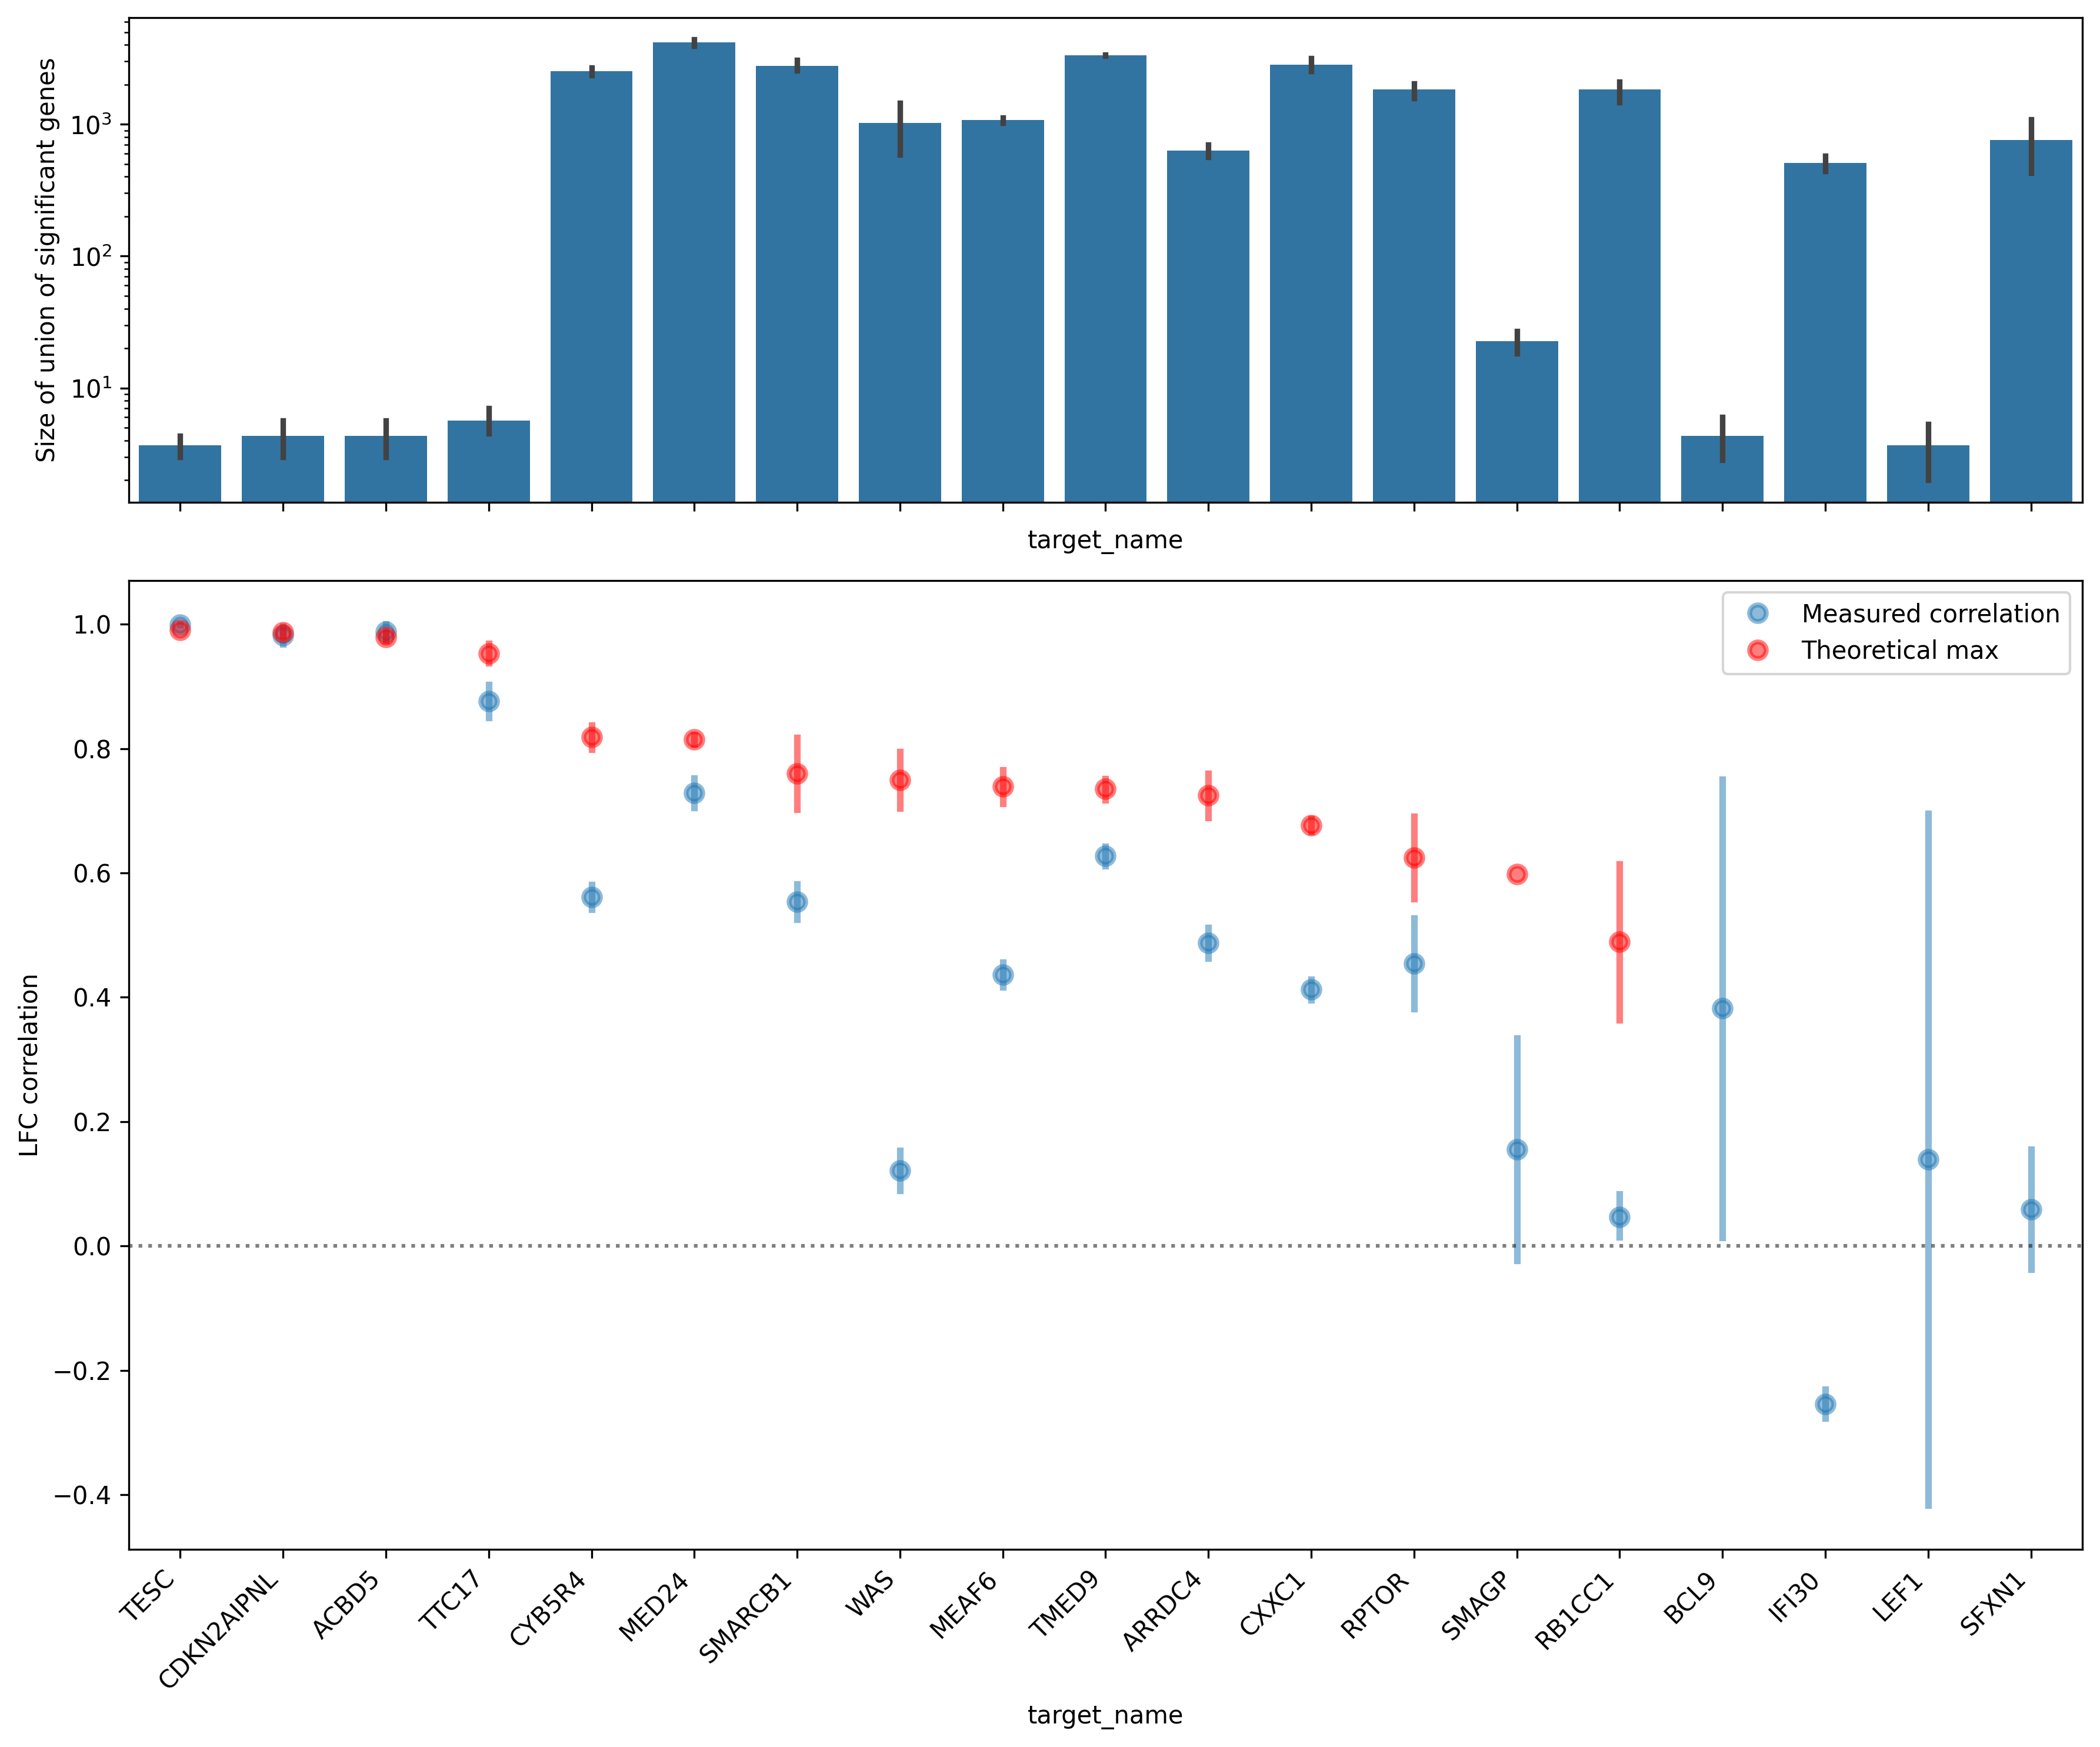

In [53]:
# Calculate mean correlation per target to sort by
mean_corr = correlations.groupby('target_name')['correlation_ceiling'].mean().sort_values(ascending=False)
sorted_targets = mean_corr.index

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[1, 2])

# Top subplot - mean number of significant genes
sns.barplot(data=correlations, x='target_name', y='n_signif', ax=ax1, order=sorted_targets)
ax1.set_xticklabels([]) # Hide x labels on top plot
ax1.set_ylabel('Size of union of significant genes')
ax1.set_yscale('log')

# Bottom subplot - correlations
sns.pointplot(data=correlations, x='target_name', y='correlation',
              order=sorted_targets, alpha=0.5, ax=ax2, linestyles='', label='Measured correlation')
sns.pointplot(data=correlations, x='target_name', y='correlation_ceiling',
              order=sorted_targets, alpha=0.5, color='red', ax=ax2, linestyles='', label='Theoretical max')
ax2.axhline(y=0, color='black', linestyle=':', alpha=0.5)
ax2.set_ylabel('LFC correlation')
# Add legend inside plot
ax2.legend(bbox_to_anchor=(1, 1))


# Rotate x-axis labels for readability
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

# Adjust layout to prevent label cutoff
plt.tight_layout()

In [41]:
import itertools

donor_pairs = all_results_df['donors'].unique()
comparison_pairs = []
for pair1, pair2 in itertools.combinations(donor_pairs, 2):
    donors1 = set(pair1.split('_'))
    donors2 = set(pair2.split('_'))
    if donors1.isdisjoint(donors2):
        comparison_pairs.append((pair1, pair2))

pivoted = all_results_df.pivot(columns='donors', index=['target','variable'], values='zscore')
pivoted_se = all_results_df.pivot(columns='donors', index=['target','variable'], values='lfcSE')
pivoted_pval = all_results_df.pivot(columns='donors', index=['target','variable'], values='adj_p_value')
correlations = pd.DataFrame()
for target in pivoted.index.get_level_values('target').unique():
    target_data = pivoted.loc[target]
    target_se = pivoted_se.loc[target]
    target_p = pivoted_pval.loc[target]
    
    # Calculate correlations and F1 scores for specified pairs
    pair_correlations = []
    for pair in comparison_pairs:
        if pair[0] in target_data.columns and pair[1] in target_data.columns:
            # Get mask for genes with p < 0.1 in either test
            sig_mask = (target_p[pair[0]] < 0.2) | (target_p[pair[1]] < 0.2)
            # sig_mask = (np.abs(target_data[pair[0]]) > 0.1) | (np.abs(target_data[pair[1]]) > 0.1)
            
            # Filter data using mask
            data1 = target_data[pair[0]][sig_mask]
            data2 = target_data[pair[1]][sig_mask]
            se1 = target_se[pair[0]][sig_mask]
            se2 = target_se[pair[1]][sig_mask]
            
            corr, corr_ceil = get_lfc_correlation(data1, se1, data2, se2)

            pair_correlations.append({
                'target': target,
                'donors': pair[0],
                'variable': pair[1],
                'correlation': corr,
                'correlation_ceiling': corr_ceil,
                'n_signif':data1.shape[0]
            })
    correlations = pd.concat([correlations, pd.DataFrame(pair_correlations)])
    
    correlations = pd.concat([correlations, pd.DataFrame(pair_correlations)])

correlations = pd.merge(correlations.rename({'target':'target_contrast'}, axis=1), de_counts[de_counts['condition'] == cond], how='left')
correlations

/tmp/ipykernel_4020663/2298880084.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(rel_a * rel_b)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


target_contrast               donors             variable  correlation  \
0    ENSG00000008838  CE0006864_CE0008162  CE0010866_CE0008678     0.681650   
1    ENSG00000008838  CE0006864_CE0010866  CE0008162_CE0008678     0.755650   
2    ENSG00000008838  CE0006864_CE0008678  CE0008162_CE0010866     0.750722   
3    ENSG00000008838  CE0006864_CE0008162  CE0010866_CE0008678     0.681650   
4    ENSG00000008838  CE0006864_CE0010866  CE0008162_CE0008678     0.755650   
..               ...                  ...                  ...          ...   
151  ENSG00000237190  CE0006864_CE0010866  CE0008162_CE0008678     0.958194   
152  ENSG00000237190  CE0006864_CE0008678  CE0008162_CE0010866     1.000000   
153  ENSG00000237190  CE0006864_CE0008162  CE0010866_CE0008678     0.801163   
154  ENSG00000237190  CE0006864_CE0010866  CE0008162_CE0008678     0.958194   
155  ENSG00000237190  CE0006864_CE0008678  CE0008162_CE0010866     1.000000   

     correlation_ceiling  n_signif target_name condition  n_cells_target  \
0               0.988327      4244       MED24   Stim8hr           700.0   
1               0.988882      4507       MED24   Stim8hr           700.0   
2               0.990104      3752       MED24   Stim8hr           700.0   
3               0.988327      4244       MED24   Stim8hr           700.0   
4               0.988882      4507       MED24   Stim8hr           700.0   
..                   ...       ...         ...       ...             ...   
151             0.996624         6  CDKN2AIPNL   Stim8hr           820.0   
152             0.999442         2  CDKN2AIPNL   Stim8hr           820.0   
153             0.999089         5  CDKN2AIPNL   Stim8hr           820.0   
154             0.996624         6  CDKN2AIPNL   Stim8hr           820.0   
155             0.999442         2  CDKN2AIPNL   Stim8hr           820.0   

     n_up_genes  n_down_genes  n_total_de_genes  ontarget_effect_size  \
0        1139.0        1656.0            2795.0            -22.112543   
1        1139.0        1656.0            2795.0            -22.112543   
2        1139.0        1656.0            2795.0            -22.112543   
3        1139.0        1656.0            2795.0            -22.112543   
4        1139.0        1656.0            2795.0            -22.112543   
..          ...           ...               ...                   ...   
151         1.0           1.0               2.0            -16.296365   
152         1.0           1.0               2.0            -16.296365   
153         1.0           1.0               2.0            -16.296365   
154         1.0           1.0               2.0            -16.296365   
155         1.0           1.0               2.0            -16.296365   

    ontarget_significant   baseMean offtarget_flag n_total_genes_category  \
0                   True  87.435833           True           >10 DE genes   
1                   True  87.435833           True           >10 DE genes   
2                   True  87.435833           True           >10 DE genes   
3                   True  87.435833           True           >10 DE genes   
4                   True  87.435833           True           >10 DE genes   
..                   ...        ...            ...                    ...   
151                 True  32.377350          False          2-10 DE genes   
152                 True  32.377350          False          2-10 DE genes   
153                 True  32.377350          False          2-10 DE genes   
154                 True  32.377350          False          2-10 DE genes   
155                 True  32.377350          False          2-10 DE genes   

    ontarget_effect_category  
0               on-target KD  
1               on-target KD  
2               on-target KD  
3               on-target KD  
4               on-target KD  
..                       ...  
151             on-target KD  
152             on-target KD  
153             on-target KD  
154             on-target KD  


/tmp/ipykernel_4020663/1803697279.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')


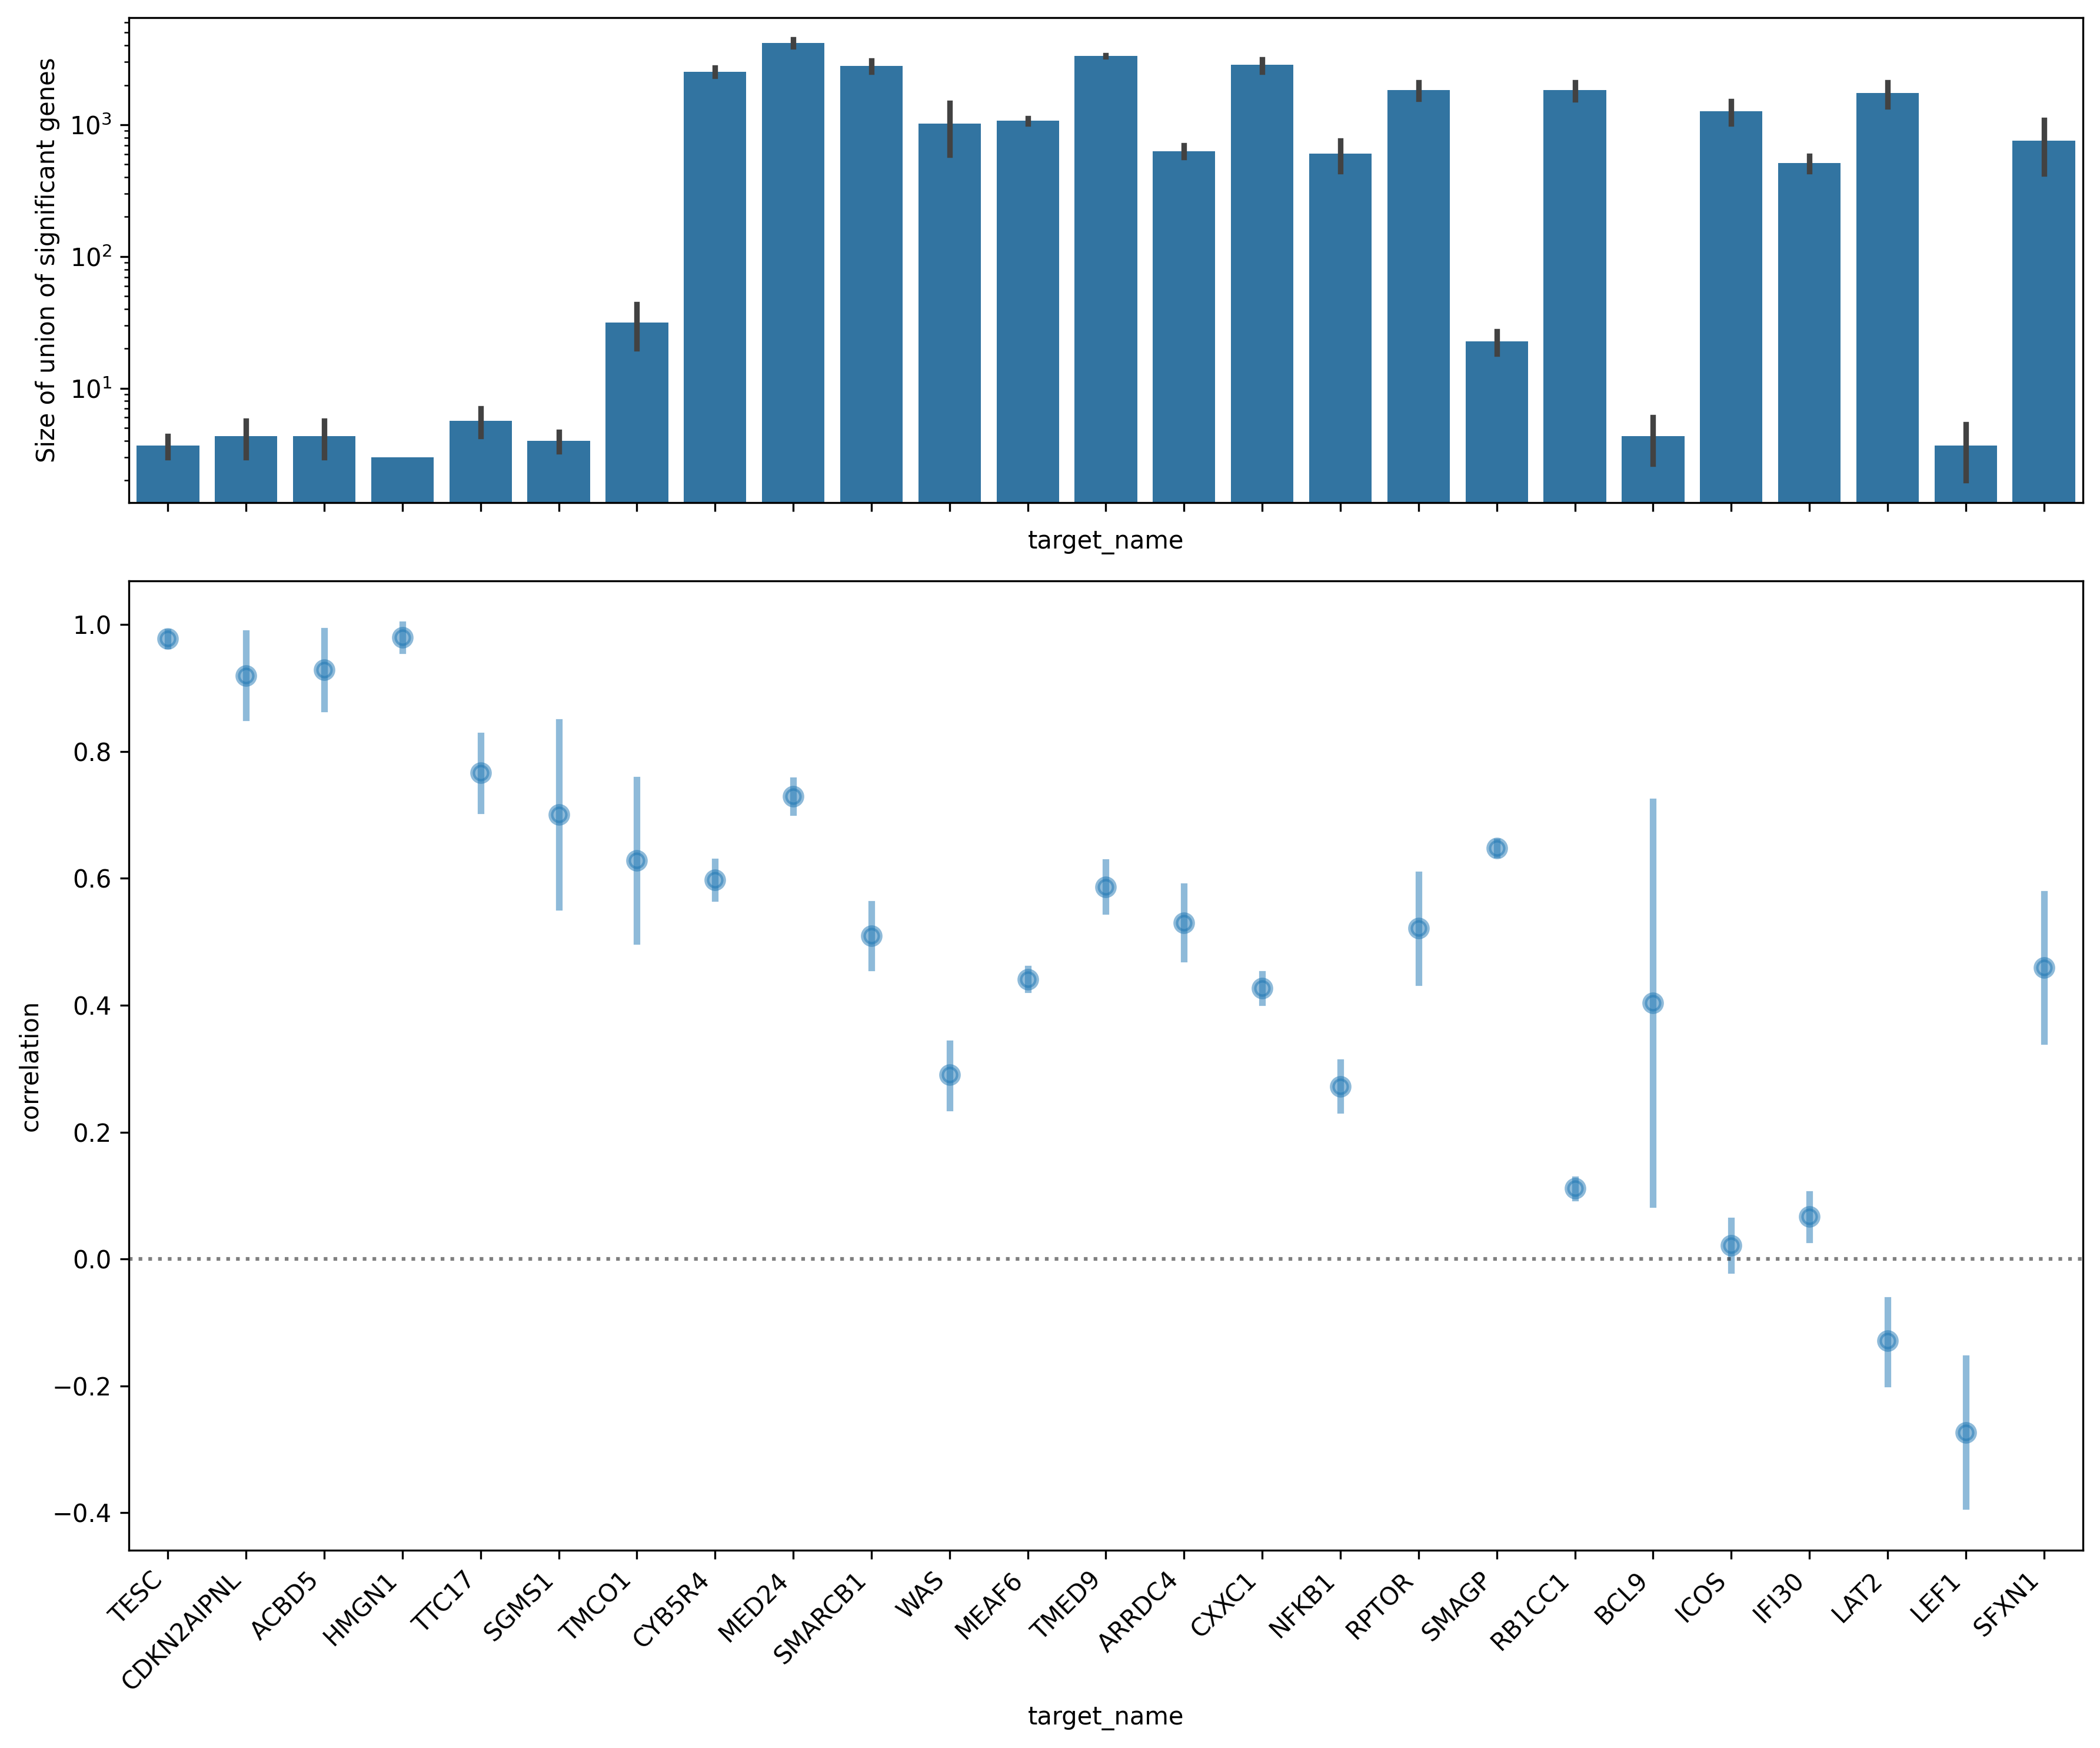

In [42]:
# # Calculate mean correlation per target to sort by
# mean_corr = correlations.groupby('target_name')['n_signif'].mean().sort_values(ascending=False)
# sorted_targets = mean_corr.index

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[1, 2])

# Top subplot - mean number of significant genes
sns.barplot(data=correlations, x='target_name', y='n_signif', ax=ax1, order=sorted_targets)
ax1.set_xticklabels([]) # Hide x labels on top plot
ax1.set_ylabel('Size of union of significant genes')
ax1.set_yscale('log')

# Bottom subplot - correlations
sns.pointplot(data=correlations, x='target_name', y='correlation',
              order=sorted_targets, alpha=0.5, ax=ax2, linestyles='')
# sns.pointplot(data=correlations, x='target_name', y='correlation_ceiling',
#               order=sorted_targets, alpha=0.5, color='red', ax=ax2, linestyles='')
ax2.axhline(y=0, color='black', linestyle=':', alpha=0.5)

# Rotate x-axis labels for readability
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

# Adjust layout to prevent label cutoff
plt.tight_layout()

## Check consistency on specific genes

In [80]:
DE_test_vars = anndata.experimental.read_lazy(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results.h5ad').var.to_dataframe()
all_results_df = pd.merge(all_results_df.rename({'variable':'gene_ids'}, axis=1), DE_test_vars, how='left')
all_results_df = pd.merge(all_results_df.rename({'target':'target_contrast'}, axis=1), de_counts[de_counts['condition'] == cond][['target_contrast','target_name']], how='left')

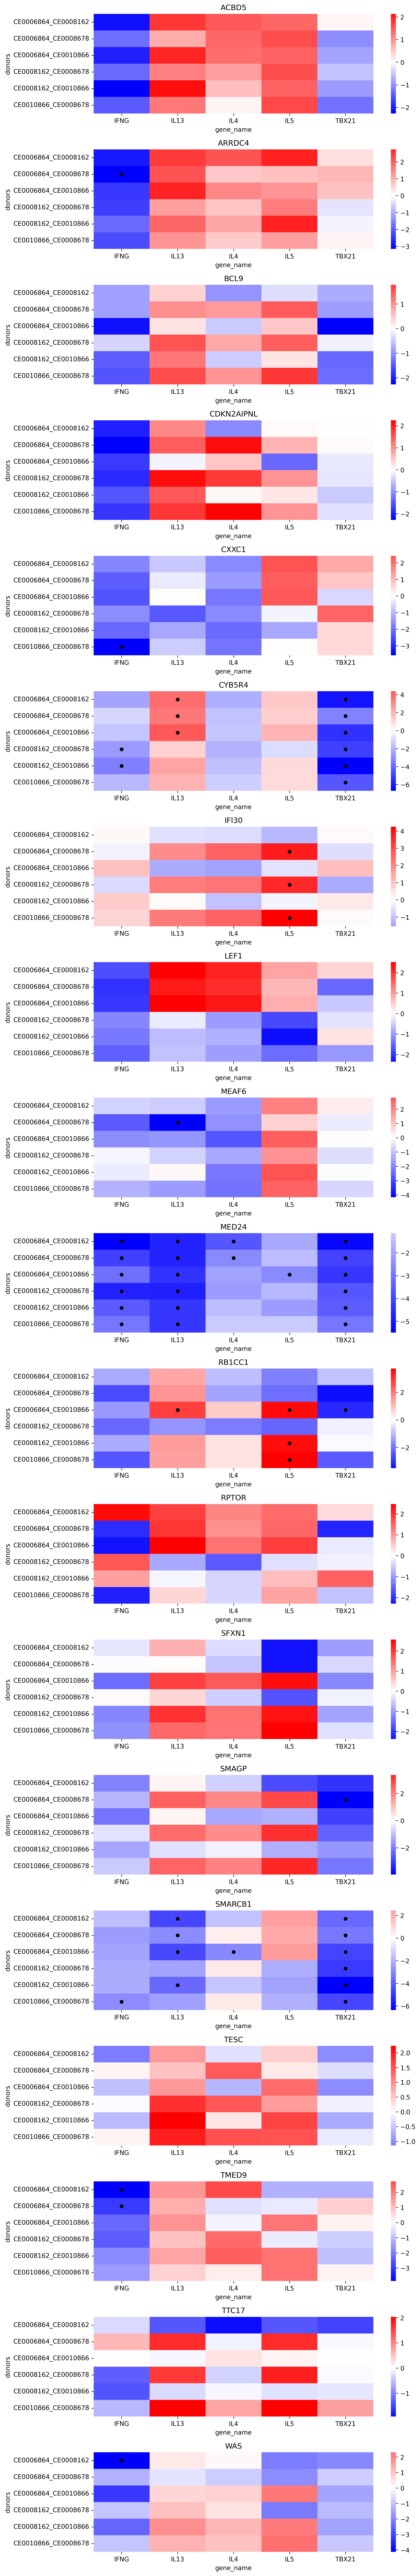

In [109]:
genes_oi = ['TBX21', 'IFNG', 'IL4', 'IL5', 'IL13']

pl_df = all_results_df[all_results_df['gene_name'].isin(genes_oi) & all_results_df.target_name.isin(Th2_regulators)]
signif_pl_df = pl_df.pivot(columns='gene_name', index=['target_name','donors'], values='adj_p_value')
signif_pl_df = signif_pl_df < 0.1
pl_df = pl_df.pivot(columns='gene_name', index=['target_name','donors'], values='zscore')

# Create a subplot for each target
targets = pl_df.index.get_level_values('target_name').unique()
fig, axes = plt.subplots(len(targets), 1, figsize=(10, 3*len(targets)))

for i, target in enumerate(targets):
    target_data = pl_df.loc[target]
    signif_data = signif_pl_df.loc[target]
    
    # Create heatmap
    sns.heatmap(target_data, cmap='bwr', center=0, 
                ax=axes[i], cbar=True)
    
    # Add dots for significant results
    for j, donor in enumerate(target_data.index):
        for k, gene in enumerate(target_data.columns):
            if signif_data.loc[donor, gene]:
                axes[i].plot(k + 0.5, j + 0.5, 'k.', markersize=10)
    
    axes[i].set_title(target)
    axes[i].set_xticklabels(target_data.columns)

plt.tight_layout()


## Compare estimates on all donors

In [26]:
sys.path.append(os.path.abspath('../'))
from DE_analysis_utils import *

In [20]:
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results.h5ad')


In [25]:
adata_de[adata_de.obs['target_contrast_gene_name'] == 'NEUROG2'].obs

target_contrast_gene_name culture_condition  \
ENSG00000178403_Stim8hr                    NEUROG2           Stim8hr   
ENSG00000178403_Rest                       NEUROG2              Rest   
ENSG00000178403_Stim48hr                   NEUROG2          Stim48hr   

                          target_contrast chunk  n_cells_target  
ENSG00000178403_Stim8hr   ENSG00000178403    70          1261.0  
ENSG00000178403_Rest      ENSG00000178403   484          1196.0  
ENSG00000178403_Stim48hr  ENSG00000178403   627          1293.0

In [29]:
t = 'NEUROG2'
DE_results = get_DE_results_long(
        adata_de,
        targets=[t], 
        effect_estimates = ['log_fc', 'lfcSE'],
        signif_estimate = 'adj_p_value',
        target_id_col = 'target_contrast_gene_name',
        gene_id_col='gene_name'
    )
DE_results = DE_results[DE_results['culture_condition'] == 'Stim8hr'].copy()
# DE_results = DE_results[DE_results['significant']]

In [30]:
DE_results

index             gene    log_fc     lfcSE  \
27918  ENSG00000178403_Stim8hr  ENSG00000000003  0.143627  5.310099   
27919  ENSG00000178403_Stim8hr  ENSG00000000419  0.010622  0.037350   
27920  ENSG00000178403_Stim8hr  ENSG00000000457  0.076317  0.083286   
27921  ENSG00000178403_Stim8hr  ENSG00000000460  0.063064  0.088724   
27922  ENSG00000178403_Stim8hr  ENSG00000000938  1.348444  1.143941   
...                        ...              ...       ...       ...   
41872  ENSG00000178403_Stim8hr  ENSG00000290292  0.043471  0.110714   
41873  ENSG00000178403_Stim8hr  ENSG00000290795       NaN       NaN   
41874  ENSG00000178403_Stim8hr  ENSG00000290797       NaN       NaN   
41875  ENSG00000178403_Stim8hr  ENSG00000291096       NaN       NaN   
41876  ENSG00000178403_Stim8hr  ENSG00000291237  0.011926  0.078448   

       adj_p_value  significant        gene_name culture_condition  \
27918     0.999815        False           TSPAN6           Stim8hr   
27919     0.999815        False             DPM1           Stim8hr   
27920     0.999815        False            SCYL3           Stim8hr   
27921     0.999815        False         C1orf112           Stim8hr   
27922     0.999815        False              FGR           Stim8hr   
...            ...          ...              ...               ...   
41872     0.999815        False            HOMEZ           Stim8hr   
41873          NaN        False          C2orf83           Stim8hr   
41874          NaN        False  ENSG00000290797           Stim8hr   
41875          NaN        False  ENSG00000291096           Stim8hr   
41876     0.999815        False             SOD2           Stim8hr   

       target_contrast target_contrast_gene_name  
27918  ENSG00000178403                   NEUROG2  
27919  ENSG00000178403                   NEUROG2  
27920  ENSG00000178403                   NEUROG2  
27921  ENSG00000178403                   NEUROG2  
27922  ENSG00000178403                   NEUROG2  
...                ...                       ...  
41872  ENSG00000178403                   NEUROG2  
41873  ENSG00000178403                   NEUROG2  
41874  ENSG00000178403                   NEUROG2  
41875  ENSG00000178403                   NEUROG2  
41876  ENSG00000178403                   NEUROG2  

[13959 rows x 10 columns]

In [164]:
# Get full results and split results
full_results = DE_results.set_index('gene')['log_fc']
split_results = all_results_df[all_results_df.target_name == t].pivot(columns='donors', index=['gene_ids'], values='log_fc')

# Find common genes between full and split results
common_genes = np.intersect1d(full_results.index, split_results.index.get_level_values('gene_ids'))

# Filter both dataframes to only include common genes
full_results_common = full_results.loc[common_genes]
split_results_common = split_results.loc[split_results.index.get_level_values('gene_ids').isin(common_genes)]
# Create figure and axes
n_pairs = split_results_common.shape[1]
n_cols = 2
n_rows = (n_pairs + 1) // 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 8*n_rows))
axes = axes.flatten()

# Plot scatter for each donor pair
for i, donor_pair in enumerate(split_results_common.columns):
    # Plot scatter with seaborn
    sns.scatterplot(x=full_results_common, y=split_results_common.iloc[:, i], ax=axes[i])
    
    # Add diagonal line
    lims = [
        min(axes[i].get_xlim()[0], axes[i].get_ylim()[0]),
        max(axes[i].get_xlim()[1], axes[i].get_ylim()[1]),
    ]
    axes[i].plot(lims, lims, 'k--', alpha=0.5, zorder=0)
    
    # Set labels
    axes[i].set_xlabel('Log2 fold change (all donors)')
    axes[i].set_ylabel('Log2 fold change (donor pair)')
    
    # Set title
    axes[i].set_title(f'Comparison of DE results: All donors vs {donor_pair}')

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

## Th1 regulators

Using list curated by Ron

```bash
PERTURBS=$(tr '\n' ',' < th1regulators.txt | sed 's/,$//')
python get_donor_robustness.py --condition Stim8hr --target $PERTURBS
python get_donor_robustness.py --condition Rest --target $PERTURBS
python get_donor_robustness.py --condition Stim48hr --target $PERTURBS
```

In [19]:
all_correlations = pd.DataFrame()
for cond in ['Rest', 'Stim8hr', 'Stim48hr']:
    Th1_regulators = pd.read_table('th1regulators.txt', header=None)[0].tolist()
    parquet_files = glob.glob(f"{results_dir}/DE_donor_robustness.*{cond}.parquet")
    all_results_df = pd.concat([pd.read_parquet(f) for f in parquet_files], ignore_index=True)
    all_results_df['zscore'] = all_results_df['log_fc']/all_results_df['lfcSE']
    all_results_df = all_results_df[all_results_df['culture_condition'] == cond]

    donor_pairs = all_results_df['donors'].unique()
    comparison_pairs = []
    for pair1, pair2 in itertools.combinations(donor_pairs, 2):
        donors1 = set(pair1.split('_'))
        donors2 = set(pair2.split('_'))
        if donors1.isdisjoint(donors2):
            comparison_pairs.append((pair1, pair2))

    pivoted = all_results_df.pivot(columns='donors', index=['target','variable'], values='log_fc')
    pivoted_se = all_results_df.pivot(columns='donors', index=['target','variable'], values='lfcSE')
    pivoted_pval = all_results_df.pivot(columns='donors', index=['target','variable'], values='adj_p_value')
    correlations = pd.DataFrame()
    for target in pivoted.index.get_level_values('target').unique():
        target_data = pivoted.loc[target]
        target_se = pivoted_se.loc[target]
        target_p = pivoted_pval.loc[target]
        
        # Calculate correlations and F1 scores for specified pairs
        pair_correlations = []
        for pair in comparison_pairs:
            if pair[0] in target_data.columns and pair[1] in target_data.columns:
                # Get mask for genes with p < 0.1 in either test
                sig_mask = (target_p[pair[0]] < 0.1) | (target_p[pair[1]] < 0.1)
                # sig_mask = (np.abs(target_data[pair[0]]) > 0.1) | (np.abs(target_data[pair[1]]) > 0.1)
                
                # Filter data using mask
                data1 = target_data[pair[0]][sig_mask]
                data2 = target_data[pair[1]][sig_mask]
                se1 = target_se[pair[0]][sig_mask]
                se2 = target_se[pair[1]][sig_mask]
                
                corr, corr_ceil = get_lfc_correlation(data1, se1, data2, se2)

                pair_correlations.append({
                    'target': target,
                    'donors': pair[0],
                    'variable': pair[1],
                    'correlation': corr,
                    'correlation_ceiling': corr_ceil,
                    'n_signif':data1.shape[0]
                })
        correlations = pd.concat([correlations, pd.DataFrame(pair_correlations)])
        
        correlations = pd.concat([correlations, pd.DataFrame(pair_correlations)])

    correlations = pd.merge(correlations.rename({'target':'target_contrast'}, axis=1), de_counts[de_counts['condition'] == cond], how='left')
    correlations = correlations[correlations.target_name.isin(Th1_regulators)]
    correlations['condition'] = cond
    all_correlations= pd.concat([all_correlations, correlations])

/tmp/ipykernel_3594776/3615270918.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(rel_a * rel_b)
/tmp/ipykernel_3594776/3615270918.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(rel_a * rel_b)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/tmp/ipykernel_3594776/3615270918.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(rel_a * rel_b)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/si

/tmp/ipykernel_3594776/1904281278.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,i].set_xticklabels(axes[1,i].get_xticklabels(), rotation=45, ha='right', fontsize=12)
/tmp/ipykernel_3594776/1904281278.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,i].set_xticklabels(axes[1,i].get_xticklabels(), rotation=45, ha='right', fontsize=12)
/tmp/ipykernel_3594776/1904281278.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,i].set_xticklabels(axes[1,i].get_xticklabels(), rotation=45, ha='right', fontsize=12)


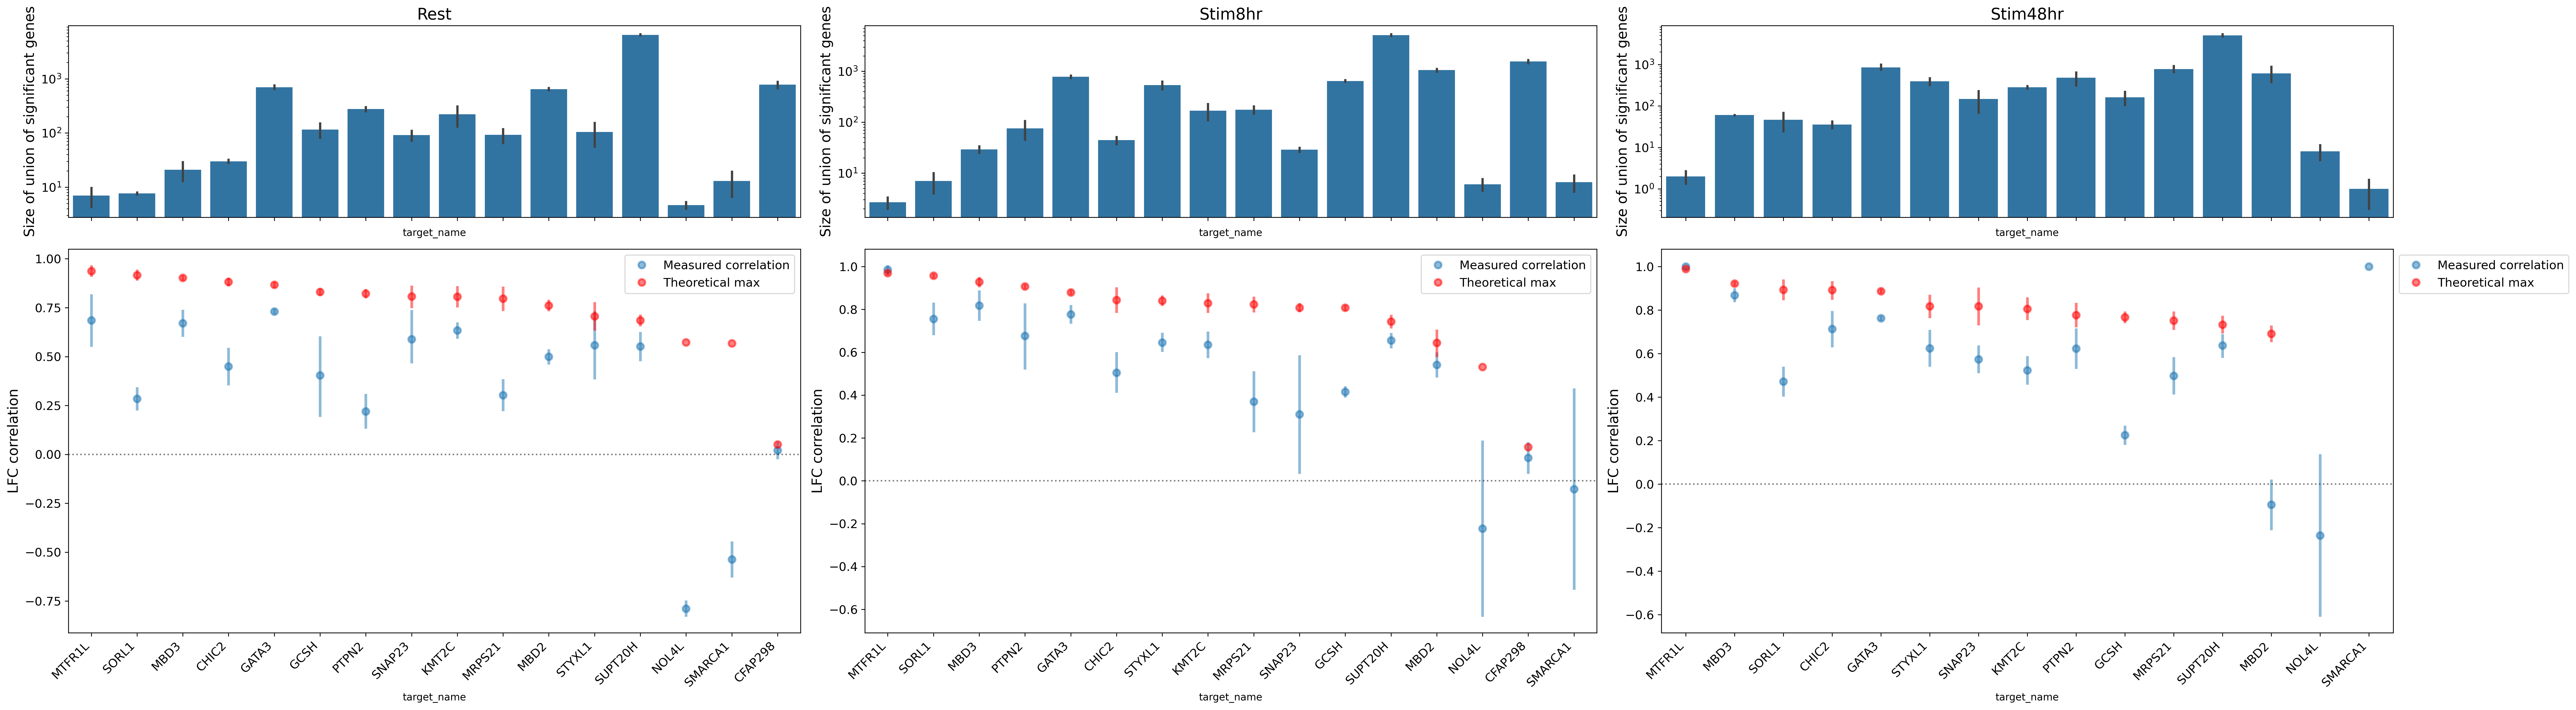

In [20]:
# Create figure with subplots for all conditions side by side
fig, axes = plt.subplots(2, 3, figsize=(36, 10), height_ratios=[1, 2])

for i, cond in enumerate(['Rest', "Stim8hr", 'Stim48hr']):
    correlations = all_correlations[all_correlations['condition'] == cond]
    # Calculate mean correlation per target to sort by
    mean_corr = correlations.groupby('target_name')['correlation_ceiling'].mean().sort_values(ascending=False)
    sorted_targets = mean_corr.index

    # Top subplot - mean number of significant genes
    sns.barplot(data=correlations, x='target_name', y='n_signif', ax=axes[0,i], order=sorted_targets)
    axes[0,i].set_xticklabels([]) # Hide x labels on top plot
    axes[0,i].set_ylabel('Size of union of significant genes', fontsize=14)
    axes[0,i].set_yscale('log')
    axes[0,i].set_title(cond, fontsize=16)
    axes[0,i].tick_params(axis='both', labelsize=12)

    # Bottom subplot - correlations
    sns.pointplot(data=correlations, x='target_name', y='correlation',
                order=sorted_targets, alpha=0.5, ax=axes[1,i], linestyles='', label='Measured correlation')
    sns.pointplot(data=correlations, x='target_name', y='correlation_ceiling',
                order=sorted_targets, alpha=0.5, color='red', ax=axes[1,i], linestyles='', label='Theoretical max')
    axes[1,i].axhline(y=0, color='black', linestyle=':', alpha=0.5)
    axes[1,i].set_ylabel('LFC correlation', fontsize=14)
    axes[1,i].tick_params(axis='both', labelsize=12)
    # Add legend inside plotc
    axes[1,i].legend(bbox_to_anchor=(1, 1), fontsize=12)

    # Rotate x-axis labels for readability
    axes[1,i].set_xticklabels(axes[1,i].get_xticklabels(), rotation=45, ha='right', fontsize=12)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

## Cytotoxicity regulators

Using list curated by Ron

```bash
PERTURBS=$(tr '\n' ',' < cytotoxic_regulators.txt | sed 's/,$//')
python get_donor_robustness.py --condition Stim8hr --target $PERTURBS
python get_donor_robustness.py --condition Rest --target $PERTURBS
python get_donor_robustness.py --condition Stim48hr --target $PERTURBS
```

In [11]:
all_correlations = pd.DataFrame()
for cond in ['Rest', 'Stim8hr', 'Stim48hr']:
    Th1_regulators = pd.read_table('cytotoxic_regulators.txt', header=None)[0].tolist()
    parquet_files = glob.glob(f"{results_dir}/DE_donor_robustness.*{cond}.parquet")
    all_results_df = pd.concat([pd.read_parquet(f) for f in parquet_files], ignore_index=True)
    all_results_df['zscore'] = all_results_df['log_fc']/all_results_df['lfcSE']
    all_results_df = all_results_df[all_results_df['culture_condition'] == cond]

    donor_pairs = all_results_df['donors'].unique()
    comparison_pairs = []
    for pair1, pair2 in itertools.combinations(donor_pairs, 2):
        donors1 = set(pair1.split('_'))
        donors2 = set(pair2.split('_'))
        if donors1.isdisjoint(donors2):
            comparison_pairs.append((pair1, pair2))

    pivoted = all_results_df.pivot(columns='donors', index=['target','variable'], values='log_fc')
    pivoted_se = all_results_df.pivot(columns='donors', index=['target','variable'], values='lfcSE')
    pivoted_pval = all_results_df.pivot(columns='donors', index=['target','variable'], values='adj_p_value')
    correlations = pd.DataFrame()
    for target in pivoted.index.get_level_values('target').unique():
        target_data = pivoted.loc[target]
        target_se = pivoted_se.loc[target]
        target_p = pivoted_pval.loc[target]
        
        # Calculate correlations and F1 scores for specified pairs
        pair_correlations = []
        for pair in comparison_pairs:
            if pair[0] in target_data.columns and pair[1] in target_data.columns:
                # Get mask for genes with p < 0.1 in either test
                sig_mask = (target_p[pair[0]] < 0.1) | (target_p[pair[1]] < 0.1)
                # sig_mask = (np.abs(target_data[pair[0]]) > 0.1) | (np.abs(target_data[pair[1]]) > 0.1)
                
                # Filter data using mask
                data1 = target_data[pair[0]][sig_mask]
                data2 = target_data[pair[1]][sig_mask]
                se1 = target_se[pair[0]][sig_mask]
                se2 = target_se[pair[1]][sig_mask]
                
                corr, corr_ceil = get_lfc_correlation(data1, se1, data2, se2)

                pair_correlations.append({
                    'target': target,
                    'donors': pair[0],
                    'variable': pair[1],
                    'correlation': corr,
                    'correlation_ceiling': corr_ceil,
                    'n_signif':data1.shape[0]
                })
        correlations = pd.concat([correlations, pd.DataFrame(pair_correlations)])
        
        correlations = pd.concat([correlations, pd.DataFrame(pair_correlations)])

    correlations = pd.merge(correlations.rename({'target':'target_contrast'}, axis=1), de_counts[de_counts['condition'] == cond], how='left')
    correlations = correlations[correlations.target_name.isin(Th1_regulators)]
    correlations['condition'] = cond
    all_correlations= pd.concat([all_correlations, correlations])

/tmp/ipykernel_3594776/3615270918.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(rel_a * rel_b)
/tmp/ipykernel_3594776/3615270918.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(rel_a * rel_b)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/tmp/ipykernel_3594776/3615270918.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(rel_a * rel_b)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/si

/tmp/ipykernel_3594776/752206639.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,i].set_xticklabels(axes[1,i].get_xticklabels(), rotation=45, ha='right', fontsize=12)
/tmp/ipykernel_3594776/752206639.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,i].set_xticklabels(axes[1,i].get_xticklabels(), rotation=45, ha='right', fontsize=12)
/tmp/ipykernel_3594776/752206639.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,i].set_xticklabels(axes[1,i].get_xticklabels(), rotation=45, ha='right', fontsize=12)


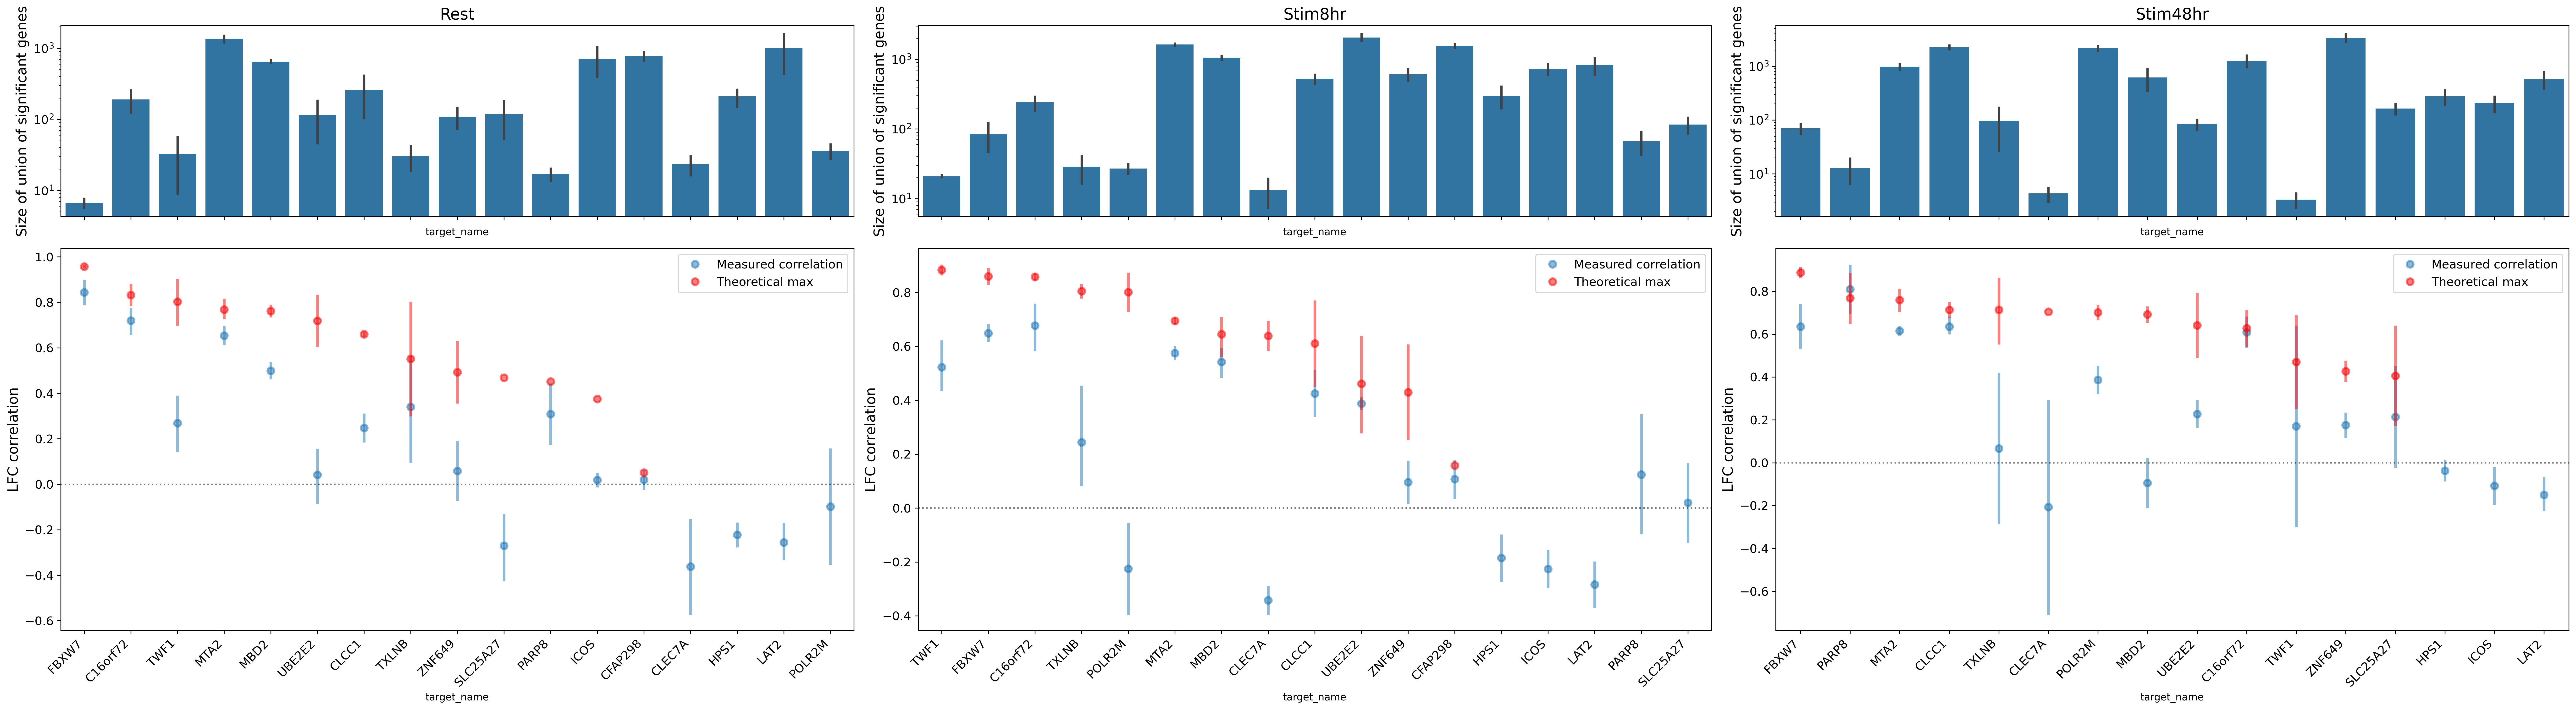

In [16]:
# Create figure with subplots for all conditions side by side
fig, axes = plt.subplots(2, 3, figsize=(36, 10), height_ratios=[1, 2])

for i, cond in enumerate(['Rest', "Stim8hr", 'Stim48hr']):
    correlations = all_correlations[all_correlations['condition'] == cond]
    # Calculate mean correlation per target to sort by
    mean_corr = correlations.groupby('target_name')['correlation_ceiling'].mean().sort_values(ascending=False)
    sorted_targets = mean_corr.index

    # Top subplot - mean number of significant genes
    sns.barplot(data=correlations, x='target_name', y='n_signif', ax=axes[0,i], order=sorted_targets)
    axes[0,i].set_xticklabels([]) # Hide x labels on top plot
    axes[0,i].set_ylabel('Size of union of significant genes', fontsize=14)
    axes[0,i].set_yscale('log')
    axes[0,i].set_title(cond, fontsize=16)
    axes[0,i].tick_params(axis='both', labelsize=12)

    # Bottom subplot - correlations
    sns.pointplot(data=correlations, x='target_name', y='correlation',
                order=sorted_targets, alpha=0.5, ax=axes[1,i], linestyles='', label='Measured correlation')
    sns.pointplot(data=correlations, x='target_name', y='correlation_ceiling',
                order=sorted_targets, alpha=0.5, color='red', ax=axes[1,i], linestyles='', label='Theoretical max')
    axes[1,i].axhline(y=0, color='black', linestyle=':', alpha=0.5)
    axes[1,i].set_ylabel('LFC correlation', fontsize=14)
    axes[1,i].tick_params(axis='both', labelsize=12)
    # Add legend inside plotc
    axes[1,i].legend(bbox_to_anchor=(1, 1), fontsize=12)

    # Rotate x-axis labels for readability
    axes[1,i].set_xticklabels(axes[1,i].get_xticklabels(), rotation=45, ha='right', fontsize=12)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()